## Analyzing 4LAC Variability

In [1]:
## main imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## astro imports
import astropy.table
from astropy import units as u
from astropy.io import fits
from astropy.io import ascii
from astropy.table import QTable, Table

from astropy.time import Time,TimeUnix
from datetime import datetime

## other imports
import os
import csv
import glob
import math
import json
import statistics

import scipy.optimize as sp
import scipy.odr.odrpack as odrpack
from scipy import signal, integrate
from scipy.fft import fft, fftfreq
from scipy.stats import pearsonr

import matplotlib.ticker as mticker
from matplotlib.ticker import FormatStrFormatter

First set the paths of the catalog files.

In [2]:
path_4lac_dr3_catalog = '../4LAC_catalog_generator_v3/resulting_catalogs/agn_pop_4lac_dr3.ecsv'
path_downloaded_lc_catalog = '../4LAC_lightcurve_downloader_v3/resulting_catalogs/input_lightcurve_downloads_v3'

path_downloaded_lc_3days = f'{path_downloaded_lc_catalog}/3days_ts1_lightcurves'
path_downloaded_lc_weekly = f'{path_downloaded_lc_catalog}/weekly_ts1_lightcurves'
path_downloaded_lc_monthly = f'{path_downloaded_lc_catalog}/monthly_ts1_lightcurves'

In [3]:
# path_4lac_dr3_catalog = '../4LAC_catalog_generator_v3/resulting_catalogs/agn_pop_4lac_dr3.ecsv'
# path_downloaded_lc_catalog = '/Users/luanareis/Documents/PhD_Astrophysics/CTA_BrighteningAnalysis'

# path_downloaded_lc_3days = f'{path_downloaded_lc_catalog}/input_lightcurve_downloads/3day_lightcurves'
# path_downloaded_lc_weekly = f'{path_downloaded_lc_catalog}/input_lightcurve_downloads/weekly_lightcurves'
# path_downloaded_lc_monthly = f'{path_downloaded_lc_catalog}/input_lightcurve_downloads/monthly_lightcurves'

In [4]:
## select every file that ends with .json in each folder
lc_3days_files = glob.glob(path_downloaded_lc_3days + '/*.json')
lc_weekly_files = glob.glob(path_downloaded_lc_weekly + '/*.json')
lc_monthly_files = glob.glob(path_downloaded_lc_monthly + '/*.json')

lc_3days_file_list = []
lc_weekly_file_list = []
lc_monthly_file_list = []

for file in lc_3days_files:
    stripped_file = os.path.basename(file)    # get file name
    lc_3days_file_list.append(stripped_file)  # create list
lc_3days_file_list.sort() # alphabetical order


for file in lc_weekly_files:
    stripped_file = os.path.basename(file)
    lc_weekly_file_list.append(stripped_file)  
lc_weekly_file_list.sort()


for file in lc_monthly_files:
    stripped_file = os.path.basename(file)
    lc_monthly_file_list.append(stripped_file)
lc_monthly_file_list.sort()

In [5]:
lc_3days_file_list == lc_weekly_file_list # same source names

True

In [6]:
lc_3days_file_list == lc_monthly_file_list

True

In [7]:
def read_json_catalog(file_name, bins=['3-days','weekly','monthly']):
    '''
    returns a dictionary and a Dataframe
    '''
    
    if (bins == '3-days'):
        file = open(f'{path_downloaded_lc_3days}/{file_name}')
    elif (bins == 'weekly'):
        file = open(f'{path_downloaded_lc_weekly}/{file_name}')
    elif (bins == 'monthly'):
        file = open(f'{path_downloaded_lc_monthly}/{file_name}')
    else:
        raise ValueError("Invalid binning option. Choose from '3-days', 'weekly', or 'monthly'.")
        
    name = file_name[5:-5]
    
    ## returns JSON object as a dictionary
    data = json.load(file)
    
    ## creating arrays to store the data
    
    ## ts = test statistics
    time_ts = np.array(data['ts'])[:, 0]
    values_ts = np.array(data['ts'])[:, 1]
    
    ## flux
    time_flux = np.array(data['flux'])[:,0]     # [i][0]
    flux = np.array(data['flux'])[:,1]          # [i][1]
    
    ## flux_upper_limits
    if np.array(data['flux_upper_limits']).ndim == 2:
        time_flux_upper_limits  = np.array(data['flux_upper_limits'])[:,0]
        flux_upper_limits  = np.array(data['flux_upper_limits'])[:,1]
    else:
        ## Handle the case where "flux_upper_limits" is not present in the file
        time_flux_upper_limits = np.array(data['flux_upper_limits'])
        flux_upper_limits = np.array(data['flux_upper_limits'])
    
    ## flux_error
    time_flux_error = np.array(data['flux_error'])[:,0]     # [i][0]
    flux_low_error  = np.array(data['flux_error'])[:,1]     # [i][1]  - lower flux edge
    flux_high_error = np.array(data['flux_error'])[:,2]     # [i][2]  - high edge
    
    ## fit_convergence
    time_fit_convergence = np.array(data['fit_convergence'])[:,0]    #[i][0]
    fit_convergence = np.array(data['fit_convergence'])[:,1]    # [i][1] - should be zero!
    
    ## ------ error treatment ------

    ## selecting only the error bar: flux_error = flux - flux_low_error // flux_high_error - flux
    flux_point_low_error = flux - flux_low_error
    flux_point_high_error = flux_high_error - flux

    ## creating masks to select the larger error
    mask_high_larger_than_low = flux_point_high_error >= flux_point_low_error    # mask when high errors larger than low errors
    mask_low_larger_than_high = flux_point_low_error > flux_point_high_error     # low errors larger than high errors

    flux_error = np.zeros_like(flux_high_error)

    ## the flux_error will be the largest one comparing to high and low errors
    flux_error[mask_high_larger_than_low] = flux_point_high_error[mask_high_larger_than_low]
    flux_error[mask_low_larger_than_high] = flux_point_low_error[mask_low_larger_than_high]

    ## create a dictionary to hold the variables
    data_dict = {
        'name': name,
        'time_flux': time_flux,
        'flux': flux,
        'time_flux_upper_limits': time_flux_upper_limits,
        'flux_upper_limits': flux_upper_limits,
        'time_flux_error': time_flux_error,
        'flux_low_error': flux_low_error,
        'flux_high_error': flux_high_error,
        'flux_error': flux_error,
        'time_fit_convergence': time_fit_convergence,
        'fit_convergence': fit_convergence,
        'time_ts': time_ts,
        'values_ts': values_ts
    }
    
    ## create a DataFrame for the outlier treatment
    df = pd.DataFrame()

    ## assign 'time_fit_convergence' as index - the total number of observations
    df['time_fit_convergence'] = data_dict['time_fit_convergence']
    df.set_index('time_fit_convergence', inplace=True)
    df['fit_convergence'] = data_dict['fit_convergence']
    
    df['time_ts'] = data_dict['time_ts']
    df['values_ts'] = data_dict['values_ts']

    ## insert columns with NaN values
    df['flux'] = np.nan
    df['flux_upper_limits'] = np.nan
    df['flux_error'] = np.nan
    
    ## fill in the values where 'time_flux' matches the index 'time_fit_convergence'
    mask_flux = df.index.isin(data_dict['time_flux'])
    df.loc[mask_flux, 'flux'] = data_dict['flux']
    
    ## 'time_upper_lim' matches the index 'time_fit_convergence'
    mask_upper_lim = df.index.isin(data_dict['time_flux_upper_limits'])
    df.loc[mask_upper_lim, 'flux_upper_limits'] = data_dict['flux_upper_limits']

    ## 'time_flux_error' matches the index
    mask_flux_error = df.index.isin(data_dict['time_flux_error'])
    df.loc[mask_flux_error, 'flux_error'] = flux_error

    return data_dict, df

In [100]:
def func_threshold(x):
    return np.exp(-0.5 - np.log10(x))

def removing_outliers(dataframe):
    
    indices_to_remove_fit = (dataframe['fit_convergence'] != 0)    # remove fit_convergence != 0
    indices_to_remove_flux_error = (dataframe['flux_error'] == 0)  # remove flux_error == 0
    
#     ## for low exposures
#     x = dataframe['values_ts']
#     y = dataframe['flux_error'] / dataframe['flux']
#     min_threshold = func_threshold(x)
    
#     indices_to_remove_ts = (y < min_threshold)
    
    ## combine both conditions
    indices_to_remove = indices_to_remove_fit | indices_to_remove_flux_error
#     indices_to_remove = indices_to_remove_fit | indices_to_remove_flux_error | indices_to_remove_ts
    
    ## turn flux, flux_upper_limits, and flux_error to NaN where either condition is met
    dataframe.loc[indices_to_remove, ['flux', 'flux_upper_limits', 'flux_error']] = np.nan
    
    return dataframe

In [9]:
def calculate_variability(file_name, bins=['3-days','weekly','monthly']):
    ''' Description
    Variability Calculations of Fractional Variability and Excess Variance from Vaughan et al. 2003:
    ---------- Input ----------
    file_name : name of the source           (string)
    bins: binning (3-days/weekly/monthly)    (string)
    ---------- Output ----------
    normalized_excess_variance         (float)
    unc_normalized_excess_variance     (float)
    frac_variability                   (float)
    unc_frac_variability               (float)
    '''
    
    ## extracting lightcurve parameters from the downloaded .json files
    source_dictionary, source_df = read_json_catalog(file_name, bins)
    
    ## removing outliers from the dataframe
    filtered_df = removing_outliers(source_df)
#     filtered_df = source_df
    
    ## select only non-NaN values from the DataFrame for flux and flux_error
    flux_non_nan_values = filtered_df.dropna(subset=['flux'])
    flux_error_non_nan_values = filtered_df.dropna(subset=['flux_error'])

    ## get the indexes (time) of the non-NaN values
    time_flux_non_nan = flux_non_nan_values.index
    time_flux_error_non_nan = flux_error_non_nan_values.index

    ## selected flux points
    selected_flux_values = flux_non_nan_values['flux']
    selected_flux_error_values = flux_error_non_nan_values['flux_error']
    
    
    ## spectrum flux instead of simple average
    source_name = source_dictionary['name']
    
    index = df_agn_pop_4lac_dr3[df_agn_pop_4lac_dr3['Source_Name'] == source_name].index[0]
    spectrum_flux = df_agn_pop_4lac_dr3.loc[index, 'Spectrum_Flux_Estimated']


    
#     ## to ensure source name exists in the DataFrame - DR2 vs. DR3
#     if source_name in df_agn_pop_4lac_dr3['Source_Name'].values:
        
#         index = df_agn_pop_4lac_dr3[df_agn_pop_4lac_dr3['Source_Name'] == source_name].index[0]
#         spectrum_flux = df_agn_pop_4lac_dr3.loc[index, 'Spectrum_Flux_Estimated']

#         print("Spectrum Flux for", source_name, ":", spectrum_flux)
#     else:
#         print("Source name not found in DataFrame.")


        
    ##### Excess Variance #####
    
#     F_av = spectrum_flux
    F_av = np.average(selected_flux_values)  # simple average

    n = len(selected_flux_values)
    s_squared = (1 / (n - 1)) * sum((F_i - F_av)**2 for F_i in selected_flux_values)
    mse = (1/n) * sum(sigma_i**2 for sigma_i in selected_flux_error_values)
    
    excess_variance = s_squared - mse
    
    normalized_excess_variance = excess_variance / F_av**2
    
    term1 = np.sqrt(2/n) * ( mse / (F_av**2) )
    term2 = np.sqrt(mse/n) * ( 2 / F_av )
    
    unc_normalized_excess_variance = np.sqrt( (term1)**2 + ( (term2)**2 * normalized_excess_variance) )
    
    ##### Fractional Variability #####
    
    frac_variability = np.sqrt( max(normalized_excess_variance, 0) ) # 4FGL paper: max(term_max, 0)
    
    factor1 = np.sqrt( 1 / (2*n) ) * mse / ( F_av**2 )
    factor2 = np.sqrt( mse / n ) * ( 1 / F_av )
    
    if (frac_variability == 0):
        unc_frac_variability = 0.1
    else:
        unc_frac_variability = np.sqrt( ( (factor1)**2 / normalized_excess_variance ) + (factor2)**2 )
   
    return normalized_excess_variance, unc_normalized_excess_variance, frac_variability, unc_frac_variability

In [10]:
## ---------- flux obtained by the integral of SED ----------
def calculate_spectrum_flux(source_name, y_min, y_max):
    
    ''' Description
    
    ---------- Input ----------
    
    file_name : name of the source                         (string)
    y_min: lower limit of the integral in GeV (0.1 GeV)    (float)
    y_max: upper limit of the integral in GeV (100 GeV)    (float)
    
    ---------- Output ----------
    
    spectrum_flux: integrated flux from the SED         (float)
    diff_flux: differential flux dN/dE                  (float)
    spec_type: spectrum type (LogParabola/ PowerLaw)    (float)

    '''
    
    ## Get the index of the source
    index = df_agn_pop_4lac_dr3[df_agn_pop_4lac_dr3['Source_Name'] == source_name].index

    for i in index:

        ## Pivot_Energy [erg]
        E_0 = ((df_agn_pop_4lac_dr3.loc[i,'Pivot_Energy'] * u.MeV).to('erg')).value

        ## ---------- PowerLaw ----------
        if df_agn_pop_4lac_dr3.loc[i,'SpectrumType'] == 'PowerLaw':
            spec_type = "PowerLaw"

            ## PL_Flux_Density [erg-1 cm-2 s-1]
            K = ((df_agn_pop_4lac_dr3.loc[i,'PL_Flux_Density'] * u.MeV**-1 * u.cm**-2 * u.s**-1).to('erg-1 cm-2 s-1')).value
            
            ## PL_Index
            alpha = df_agn_pop_4lac_dr3.loc[i,'PL_Index']
            
            ## If PowerLaw, beta = 0
            beta = 0

            
        ## ---------- LogParabola ----------
        elif df_agn_pop_4lac_dr3.loc[i,'SpectrumType'] == 'LogParabola':
            spec_type = "LogParabola"

            ## LP_Flux_Density [erg-1 cm-2 s-1]
            K = ((df_agn_pop_4lac_dr3.loc[i,'LP_Flux_Density'] * u.MeV**-1 * u.cm**-2 * u.s**-1).to('erg-1 cm-2 s-1')).value
            
            ## LP_Index
            alpha = df_agn_pop_4lac_dr3.loc[i,'LP_Index']
            
            ## LP_beta
            beta = df_agn_pop_4lac_dr3.loc[i,'LP_beta']

            
        ## ---------- in case there is an error ----------
        else:
            print('### error ###')
    
    
    dNdE = K * ((E/E_0)**(- alpha - beta * np.log(E/E_0)))
    
    diff_flux = E**2 * dNdE
    
    flux_from_spectrum = integrate.quad(lambda x: K * ((x/E_0)**(- alpha - beta * np.log(x/E_0))), 
                                          (y_min*u.GeV).to('erg').value, (y_max*u.GeV).to('erg').value)
    
    ## [ph cm-2 s-1]
    spectrum_flux = flux_from_spectrum[0] # returning only the first value of integrateflux
    
    return spectrum_flux, diff_flux, spec_type

In [11]:
# v_nxs, unc_v_nxs, fvar, unc_fvar = calculate_variability('4FGL+J0001.2-0747.json', '3-days')

Astropy Table:

In [12]:
table_agn_pop_4lac_dr3 = astropy.table.Table.read(path_4lac_dr3_catalog, format='ascii.ecsv')

In [13]:
table_agn_pop_4lac_dr3

Source_Name,RAJ2000,DEJ2000,Redshift,SpectrumType,Pivot_Energy,PL_Flux_Density,PL_Index,LP_Flux_Density,LP_Index,LP_beta,CLASS,SED_class,Variability_Index,Frac_Variability,Unc_Frac_Variability,Flux1000,Unc_Flux1000
str13,float32,float32,float64,str11,float32,float32,float32,float32,float32,float32,str5,str3,float32,float32,float32,float32,float32
J0001.2+4741,0.3126,47.6859,-inf,PowerLaw,2420.5752,2.1560312e-14,2.2716956,2.1965499e-14,2.2540812,0.012156134,bcu,ISP,25.313953,0.67588246,0.31285,1.2597956e-10,2.8771974e-11
J0001.2-0747,0.3151,-7.7971,-inf,PowerLaw,1721.6039,2.656894e-13,2.1166923,2.842831e-13,2.0789266,0.051182024,bll,LSP,46.780693,0.40656525,0.11186972,7.471219e-10,5.041939e-11
J0001.4-0010,0.3717,-0.1699,0.461516,PowerLaw,4307.0825,6.067356e-15,1.9391596,6.4888174e-15,1.6612232,0.13243835,bll,LSP,9.272764,0.0,10.0,1.0822458e-10,2.9144395e-11
J0001.5+2113,0.3815,21.2183,1.106,LogParabola,329.77374,4.683598e-11,2.65406,5.3715615e-11,2.5141594,0.15931939,fsrq,ISP,1910.9358,0.9961379,0.21347848,1.3473536e-09,6.172809e-11
J0001.6-4156,0.4165,-41.9425,-inf,PowerLaw,4047.03,1.8815414e-14,1.7751755,2.131597e-14,1.6938646,0.07275369,bcu,HSP,26.393343,0.49097705,0.17578249,2.8218167e-10,3.0908824e-11
J0001.8-2153,0.4647,-21.8865,-inf,PowerLaw,4429.934,4.94271e-15,1.8766632,7.494641e-15,1.7166204,0.40580785,bcu,LSP,24.557972,0.90285075,0.38010666,9.04753e-11,2.4425273e-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
J2359.1+1719,359.7756,17.3225,-inf,PowerLaw,2498.8909,2.3101153e-14,2.1126761,2.739969e-14,1.9953225,0.11684519,bcu,ISP,10.333145,0.0,10.0,1.4291587e-10,2.8333176e-11
J2359.2-3134,359.8167,-31.5832,0.99,PowerLaw,633.0502,9.404723e-13,2.6442769,9.687202e-13,2.6346161,0.023825364,fsrq,LSP,82.691574,1.0123546,0.2485515,1.7072874e-10,2.7292819e-11


Pandas Dataframe:

In [14]:
df_agn_pop_4lac_dr3 = table_agn_pop_4lac_dr3.to_pandas()

In [15]:
# df_agn_pop_4lac_dr3

Calculating Spectrum Flux

In [16]:
## defining Energy range in log-scale [erg]

E = ((np.logspace(np.log10(0.1), np.log10(100), 100) * u.GeV).to('erg')).value

In [17]:
spectrum_flux_values = []

for row in table_agn_pop_4lac_dr3:

    source_name = row['Source_Name']
    
    spectrum_flux = calculate_spectrum_flux(source_name, 0.1, 100)
    
    spectrum_flux_values.append(spectrum_flux[0])

table_agn_pop_4lac_dr3['Spectrum_Flux_Estimated'] = spectrum_flux_values

/var/folders/sk/6dg2gqpn01x3m5hwkj90qkgw0000gp/T/ipykernel_15624/3201124260.py:65: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  flux_from_spectrum = integrate.quad(lambda x: K * ((x/E_0)**(- alpha - beta * np.log(x/E_0))),


In [18]:
table_agn_pop_4lac_dr3

Source_Name,RAJ2000,DEJ2000,Redshift,SpectrumType,Pivot_Energy,PL_Flux_Density,PL_Index,LP_Flux_Density,LP_Index,LP_beta,CLASS,SED_class,Variability_Index,Frac_Variability,Unc_Frac_Variability,Flux1000,Unc_Flux1000,Spectrum_Flux_Estimated
str13,float32,float32,float64,str11,float32,float32,float32,float32,float32,float32,str5,str3,float32,float32,float32,float32,float32,float64
J0001.2+4741,0.3126,47.6859,-inf,PowerLaw,2420.5752,2.1560312e-14,2.2716956,2.1965499e-14,2.2540812,0.012156134,bcu,ISP,25.313953,0.67588246,0.31285,1.2597956e-10,2.8771974e-11,1.9933206471551473e-09
J0001.2-0747,0.3151,-7.7971,-inf,PowerLaw,1721.6039,2.656894e-13,2.1166923,2.842831e-13,2.0789266,0.051182024,bll,LSP,46.780693,0.40656525,0.11186972,7.471219e-10,5.041939e-11,9.825298762067532e-09
J0001.4-0010,0.3717,-0.1699,0.461516,PowerLaw,4307.0825,6.067356e-15,1.9391596,6.4888174e-15,1.6612232,0.13243835,bll,LSP,9.272764,0.0,10.0,1.0822458e-10,2.9144395e-11,8.602306897831932e-10
J0001.5+2113,0.3815,21.2183,1.106,LogParabola,329.77374,4.683598e-11,2.65406,5.3715615e-11,2.5141594,0.15931939,fsrq,ISP,1910.9358,0.9961379,0.21347848,1.3473536e-09,6.172809e-11,6.391698902983224e-08
J0001.6-4156,0.4165,-41.9425,-inf,PowerLaw,4047.03,1.8815414e-14,1.7751755,2.131597e-14,1.6938646,0.07275369,bcu,HSP,26.393343,0.49097705,0.17578249,2.8218167e-10,3.0908824e-11,1.5991319563858116e-09
J0001.8-2153,0.4647,-21.8865,-inf,PowerLaw,4429.934,4.94271e-15,1.8766632,7.494641e-15,1.7166204,0.40580785,bcu,LSP,24.557972,0.90285075,0.38010666,9.04753e-11,2.4425273e-11,6.318895028931833e-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
J2359.1+1719,359.7756,17.3225,-inf,PowerLaw,2498.8909,2.3101153e-14,2.1126761,2.739969e-14,1.9953225,0.11684519,bcu,ISP,10.333145,0.0,10.0,1.4291587e-10,2.8333176e-11,1.627887434799196e-09
J2359.2-3134,359.8167,-31.5832,0.99,PowerLaw,633.0502,9.404723e-13,2.6442769,9.687202e-13,2.6346161,0.023825364,fsrq,LSP,82.691574,1.0123546,0.2485515,1.7072874e-10,2.7292819e-11,5.776904283664661e-09


In [19]:
df_agn_pop_4lac_dr3 = table_agn_pop_4lac_dr3.to_pandas()

In [20]:
len(df_agn_pop_4lac_dr3[df_agn_pop_4lac_dr3['SED_class'] == 'HSP'])

590

In [21]:
len(df_agn_pop_4lac_dr3[df_agn_pop_4lac_dr3['SED_class'] == 'ISP'])

536

In [22]:
len(df_agn_pop_4lac_dr3[df_agn_pop_4lac_dr3['SED_class'] == 'LSP'])

1699

In [23]:
len(df_agn_pop_4lac_dr3[df_agn_pop_4lac_dr3['SED_class'] == 'HSP']) + len(df_agn_pop_4lac_dr3[df_agn_pop_4lac_dr3['SED_class'] == 'ISP']) + len(df_agn_pop_4lac_dr3[df_agn_pop_4lac_dr3['SED_class'] == 'LSP'])

2825

In [24]:
# df_agn_pop_4lac_dr3

## Calculating Variability

3-days:

In [25]:
df_copy_3days = df_agn_pop_4lac_dr3.copy()

In [26]:
file_names_Vaughan_3days = []
norm_excessvar_Vaughan_3days = []
unc_norm_excessvar_Vaughan_3days = []
fvar_Vaughan_3days = []
unc_fvar_Vaughan_3days = []

for file in lc_3days_file_list:
    
    file_name = file  # .json file name
    
    sigma_nxs, unc_sigma_nxs, fvar, unc_fvar = calculate_variability(file_name,'3-days')
    
    file_names_Vaughan_3days.append(file_name[5:-5])
    norm_excessvar_Vaughan_3days.append(sigma_nxs)
    unc_norm_excessvar_Vaughan_3days.append(unc_sigma_nxs)
    fvar_Vaughan_3days.append(fvar)
    unc_fvar_Vaughan_3days.append(unc_fvar)

df_Vaughan_variability_3days = pd.DataFrame(list(zip(file_names_Vaughan_3days,
                                                     norm_excessvar_Vaughan_3days, unc_norm_excessvar_Vaughan_3days,
                                                     fvar_Vaughan_3days, unc_fvar_Vaughan_3days)),
                                            columns =['Source_Name', 'Norm_Excess_Variance_Estimated', 'Unc_Norm_Excess_Variance_Estimated',
                                                      'Frac_Variability_Estimated', 'Unc_Frac_Variability_Estimated'])

/Users/luanareis/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/sk/6dg2gqpn01x3m5hwkj90qkgw0000gp/T/ipykernel_15624/2278892809.py:70: RuntimeWarning: invalid value encountered in sqrt
  unc_normalized_excess_variance = np.sqrt( (term1)**2 + ( (term2)**2 * normalized_excess_variance) )
/Users/luanareis/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [27]:
df_Vaughan_variability_3days

,Source_Name,Norm_Excess_Variance_Estimated,Unc_Norm_Excess_Variance_Estimated,Frac_Variability_Estimated,Unc_Frac_Variability_Estimated
0,J0001.2-0747,-0.186145,0.050238,0.000000,0.100000
1,J0001.5+2113,0.855750,0.031292,0.925067,0.016913
2,J0003.3-1928,-0.508283,NaN,0.000000,0.100000
3,J0004.3+4614,-0.394446,NaN,0.000000,0.100000
4,J0004.4-4737,-0.335834,NaN,0.000000,0.100000
...,...,...,...,...,...
1424,J2358.0-4601,-0.275635,0.016646,0.000000,0.100000
1425,J2358.3+3830,-0.602463,NaN,0.000000,0.100000
1426,J2358.3-1021,-0.186096,0.015859,0.000000,0.100000
1427,J2359.0+3922,-0.492622,NaN,0.000000,0.100000


In [28]:
# df_Vaughan_variability_3days.loc[df_Vaughan_variability_3days['Source_Name'] == 'J0028.4+2001']

In [29]:
merged_df_3days = df_copy_3days.merge(df_Vaughan_variability_3days, on='Source_Name', how='left')

In [30]:
merged_df_3days

,Source_Name,RAJ2000,DEJ2000,Redshift,SpectrumType,Pivot_Energy,PL_Flux_Density,PL_Index,LP_Flux_Density,LP_Index,...,Variability_Index,Frac_Variability,Unc_Frac_Variability,Flux1000,Unc_Flux1000,Spectrum_Flux_Estimated,Norm_Excess_Variance_Estimated,Unc_Norm_Excess_Variance_Estimated,Frac_Variability_Estimated,Unc_Frac_Variability_Estimated
0,J0001.2+4741,0.312600,47.685902,-inf,PowerLaw,2420.575195,2.156031e-14,2.271696,2.196550e-14,2.254081,...,25.313953,0.675882,0.312850,1.259796e-10,2.877197e-11,1.993321e-09,NaN,NaN,NaN,NaN
1,J0001.2-0747,0.315100,-7.797100,-inf,PowerLaw,1721.603882,2.656894e-13,2.116692,2.842831e-13,2.078927,...,46.780693,0.406565,0.111870,7.471219e-10,5.041939e-11,9.825299e-09,-0.186145,0.050238,0.000000,0.100000
2,J0001.4-0010,0.371700,-0.169900,0.461516,PowerLaw,4307.082520,6.067356e-15,1.939160,6.488817e-15,1.661223,...,9.272764,0.000000,10.000000,1.082246e-10,2.914440e-11,8.602307e-10,NaN,NaN,NaN,NaN
3,J0001.5+2113,0.381500,21.218300,1.106000,LogParabola,329.773743,4.683598e-11,2.654060,5.371562e-11,2.514159,...,1910.935791,0.996138,0.213478,1.347354e-09,6.172809e-11,6.391699e-08,0.855750,0.031292,0.925067,0.016913
4,J0001.6-4156,0.416500,-41.942501,-inf,PowerLaw,4047.030029,1.881541e-14,1.775175,2.131597e-14,1.693865,...,26.393343,0.490977,0.175782,2.821817e-10,3.090882e-11,1.599132e-09,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3809,J2359.3+0215,359.832886,2.260300,-inf,LogParabola,5170.603516,5.111725e-15,1.757034,9.790216e-15,1.644894,...,16.065315,0.311971,0.625833,1.354202e-10,3.092540e-11,1.655760e-10,NaN,NaN,NaN,NaN
3810,J2359.3-2049,359.835693,-20.818899,0.096000,PowerLaw,2594.249756,5.196033e-14,1.984188,5.197384e-14,1.982751,...,14.043210,0.177217,0.190973,3.462985e-10,3.494565e-11,3.021906e-09,NaN,NaN,NaN,NaN
3811,J2359.7-5041,359.936493,-50.685299,-inf,LogParabola,842.054199,1.846089e-13,2.684101,3.137423e-13,2.596392,...,7.732565,0.000000,10.000000,8.286240e-11,2.406248e-11,1.205902e-09,NaN,NaN,NaN,NaN
3812,J2359.9-3736,359.981598,-37.616001,-inf,PowerLaw,1730.675415,6.743669e-14,2.120209,8.021262e-14,2.007299,...,8.143241,0.000000,10.000000,1.915395e-10,2.659639e-11,2.216054e-09,NaN,NaN,NaN,NaN


In [31]:
# merged_df_3days.loc[merged_df_3days['Source_Name'] == 'J0028.4+2001']

In [32]:
table_agn_pop_4lac_dr3_variability_3days = Table.from_pandas(merged_df_3days)

table_agn_pop_4lac_dr3_variability_3days.write('./resulting_catalogs/variability_3days_agn_pop_4lac_dr3.ecsv', format='ascii.ecsv', overwrite=True)
table_agn_pop_4lac_dr3_variability_3days.write('./resulting_catalogs/variability_3days_agn_pop_4lac_dr3.fits', format='fits', overwrite=True)

Weekly:

In [33]:
df_copy_weekly = df_agn_pop_4lac_dr3.copy()

In [34]:
file_names_Vaughan_weekly = []
norm_excessvar_Vaughan_weekly = []
unc_norm_excessvar_Vaughan_weekly = []
fvar_Vaughan_weekly = []
unc_fvar_Vaughan_weekly = []

for file in lc_weekly_file_list:
    
    file_name = file  # .json file name
    
    sigma_nxs, unc_sigma_nxs, fvar, unc_fvar = calculate_variability(file_name,'weekly')
    
    file_names_Vaughan_weekly.append(file_name[5:-5])
    norm_excessvar_Vaughan_weekly.append(sigma_nxs)
    unc_norm_excessvar_Vaughan_weekly.append(unc_sigma_nxs)
    fvar_Vaughan_weekly.append(fvar)
    unc_fvar_Vaughan_weekly.append(unc_fvar)

df_Vaughan_variability_weekly = pd.DataFrame(list(zip(file_names_Vaughan_weekly,
                                                     norm_excessvar_Vaughan_weekly, unc_norm_excessvar_Vaughan_weekly,
                                                     fvar_Vaughan_weekly, unc_fvar_Vaughan_weekly)),
                                            columns =['Source_Name', 'Norm_Excess_Variance_Estimated', 'Unc_Norm_Excess_Variance_Estimated',
                                                      'Frac_Variability_Estimated', 'Unc_Frac_Variability_Estimated'])


/Users/luanareis/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/sk/6dg2gqpn01x3m5hwkj90qkgw0000gp/T/ipykernel_15624/2278892809.py:70: RuntimeWarning: invalid value encountered in sqrt
  unc_normalized_excess_variance = np.sqrt( (term1)**2 + ( (term2)**2 * normalized_excess_variance) )
/Users/luanareis/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [35]:
df_Vaughan_variability_weekly

,Source_Name,Norm_Excess_Variance_Estimated,Unc_Norm_Excess_Variance_Estimated,Frac_Variability_Estimated,Unc_Frac_Variability_Estimated
0,J0001.2-0747,-0.365964,0.027488,0.000000,0.10000
1,J0001.5+2113,1.082457,0.036207,1.040412,0.01740
2,J0003.3-1928,-0.375173,NaN,0.000000,0.10000
3,J0004.3+4614,-0.243440,0.021969,0.000000,0.10000
4,J0004.4-4737,-0.161604,0.025569,0.000000,0.10000
...,...,...,...,...,...
1424,J2358.0-4601,2.758934,3.100563,1.661004,0.93334
1425,J2358.3+3830,-0.473258,NaN,0.000000,0.10000
1426,J2358.3-1021,-0.005454,0.027840,0.000000,0.10000
1427,J2359.0+3922,-0.374555,NaN,0.000000,0.10000


In [36]:
merged_df_weekly = df_copy_weekly.merge(df_Vaughan_variability_weekly, on='Source_Name', how='left')

In [37]:
merged_df_weekly

,Source_Name,RAJ2000,DEJ2000,Redshift,SpectrumType,Pivot_Energy,PL_Flux_Density,PL_Index,LP_Flux_Density,LP_Index,...,Variability_Index,Frac_Variability,Unc_Frac_Variability,Flux1000,Unc_Flux1000,Spectrum_Flux_Estimated,Norm_Excess_Variance_Estimated,Unc_Norm_Excess_Variance_Estimated,Frac_Variability_Estimated,Unc_Frac_Variability_Estimated
0,J0001.2+4741,0.312600,47.685902,-inf,PowerLaw,2420.575195,2.156031e-14,2.271696,2.196550e-14,2.254081,...,25.313953,0.675882,0.312850,1.259796e-10,2.877197e-11,1.993321e-09,NaN,NaN,NaN,NaN
1,J0001.2-0747,0.315100,-7.797100,-inf,PowerLaw,1721.603882,2.656894e-13,2.116692,2.842831e-13,2.078927,...,46.780693,0.406565,0.111870,7.471219e-10,5.041939e-11,9.825299e-09,-0.365964,0.027488,0.000000,0.1000
2,J0001.4-0010,0.371700,-0.169900,0.461516,PowerLaw,4307.082520,6.067356e-15,1.939160,6.488817e-15,1.661223,...,9.272764,0.000000,10.000000,1.082246e-10,2.914440e-11,8.602307e-10,NaN,NaN,NaN,NaN
3,J0001.5+2113,0.381500,21.218300,1.106000,LogParabola,329.773743,4.683598e-11,2.654060,5.371562e-11,2.514159,...,1910.935791,0.996138,0.213478,1.347354e-09,6.172809e-11,6.391699e-08,1.082457,0.036207,1.040412,0.0174
4,J0001.6-4156,0.416500,-41.942501,-inf,PowerLaw,4047.030029,1.881541e-14,1.775175,2.131597e-14,1.693865,...,26.393343,0.490977,0.175782,2.821817e-10,3.090882e-11,1.599132e-09,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3809,J2359.3+0215,359.832886,2.260300,-inf,LogParabola,5170.603516,5.111725e-15,1.757034,9.790216e-15,1.644894,...,16.065315,0.311971,0.625833,1.354202e-10,3.092540e-11,1.655760e-10,NaN,NaN,NaN,NaN
3810,J2359.3-2049,359.835693,-20.818899,0.096000,PowerLaw,2594.249756,5.196033e-14,1.984188,5.197384e-14,1.982751,...,14.043210,0.177217,0.190973,3.462985e-10,3.494565e-11,3.021906e-09,NaN,NaN,NaN,NaN
3811,J2359.7-5041,359.936493,-50.685299,-inf,LogParabola,842.054199,1.846089e-13,2.684101,3.137423e-13,2.596392,...,7.732565,0.000000,10.000000,8.286240e-11,2.406248e-11,1.205902e-09,NaN,NaN,NaN,NaN
3812,J2359.9-3736,359.981598,-37.616001,-inf,PowerLaw,1730.675415,6.743669e-14,2.120209,8.021262e-14,2.007299,...,8.143241,0.000000,10.000000,1.915395e-10,2.659639e-11,2.216054e-09,NaN,NaN,NaN,NaN


In [38]:
table_agn_pop_4lac_dr3_variability_weekly = Table.from_pandas(merged_df_weekly)

table_agn_pop_4lac_dr3_variability_weekly.write('./resulting_catalogs/variability_weekly_agn_pop_4lac_dr3.ecsv', format='ascii.ecsv', overwrite=True)
table_agn_pop_4lac_dr3_variability_weekly.write('./resulting_catalogs/variability_weekly_agn_pop_4lac_dr3.fits', format='fits', overwrite=True)

Monthly:

In [39]:
df_copy_monthly = df_agn_pop_4lac_dr3.copy()

In [40]:
file_names_Vaughan_monthly = []
norm_excessvar_Vaughan_monthly = []
unc_norm_excessvar_Vaughan_monthly = []
fvar_Vaughan_monthly = []
unc_fvar_Vaughan_monthly = []

for file in lc_monthly_file_list:
    
    file_name = file  # .json file name
    
    sigma_nxs, unc_sigma_nxs, fvar, unc_fvar = calculate_variability(file_name,'monthly')
    
    file_names_Vaughan_monthly.append(file_name[5:-5])
    norm_excessvar_Vaughan_monthly.append(sigma_nxs)
    unc_norm_excessvar_Vaughan_monthly.append(unc_sigma_nxs)
    fvar_Vaughan_monthly.append(fvar)
    unc_fvar_Vaughan_monthly.append(unc_fvar)

df_Vaughan_variability_monthly = pd.DataFrame(list(zip(file_names_Vaughan_monthly,
                                                     norm_excessvar_Vaughan_monthly, unc_norm_excessvar_Vaughan_monthly,
                                                     fvar_Vaughan_monthly, unc_fvar_Vaughan_monthly)),
                                            columns =['Source_Name', 'Norm_Excess_Variance_Estimated', 'Unc_Norm_Excess_Variance_Estimated',
                                                      'Frac_Variability_Estimated', 'Unc_Frac_Variability_Estimated'])

/Users/luanareis/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/sk/6dg2gqpn01x3m5hwkj90qkgw0000gp/T/ipykernel_15624/2278892809.py:70: RuntimeWarning: invalid value encountered in sqrt
  unc_normalized_excess_variance = np.sqrt( (term1)**2 + ( (term2)**2 * normalized_excess_variance) )
/Users/luanareis/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [41]:
df_Vaughan_variability_monthly

,Source_Name,Norm_Excess_Variance_Estimated,Unc_Norm_Excess_Variance_Estimated,Frac_Variability_Estimated,Unc_Frac_Variability_Estimated
0,J0001.2-0747,-0.096802,0.031478,0.000000,0.100000
1,J0001.5+2113,1.495819,0.044791,1.223037,0.018311
2,J0003.3-1928,-0.079773,0.050220,0.000000,0.100000
3,J0004.3+4614,0.310443,0.084265,0.557174,0.075618
4,J0004.4-4737,0.305837,0.065895,0.553025,0.059577
...,...,...,...,...,...
1424,J2358.0-4601,0.149656,0.074019,0.386854,0.095668
1425,J2358.3+3830,-0.161026,0.267607,0.000000,0.100000
1426,J2358.3-1021,0.373402,0.052568,0.611066,0.043013
1427,J2359.0+3922,-0.147039,0.038504,0.000000,0.100000


In [42]:
merged_df_monthly = df_copy_monthly.merge(df_Vaughan_variability_monthly, on='Source_Name', how='left')

In [43]:
merged_df_monthly

,Source_Name,RAJ2000,DEJ2000,Redshift,SpectrumType,Pivot_Energy,PL_Flux_Density,PL_Index,LP_Flux_Density,LP_Index,...,Variability_Index,Frac_Variability,Unc_Frac_Variability,Flux1000,Unc_Flux1000,Spectrum_Flux_Estimated,Norm_Excess_Variance_Estimated,Unc_Norm_Excess_Variance_Estimated,Frac_Variability_Estimated,Unc_Frac_Variability_Estimated
0,J0001.2+4741,0.312600,47.685902,-inf,PowerLaw,2420.575195,2.156031e-14,2.271696,2.196550e-14,2.254081,...,25.313953,0.675882,0.312850,1.259796e-10,2.877197e-11,1.993321e-09,NaN,NaN,NaN,NaN
1,J0001.2-0747,0.315100,-7.797100,-inf,PowerLaw,1721.603882,2.656894e-13,2.116692,2.842831e-13,2.078927,...,46.780693,0.406565,0.111870,7.471219e-10,5.041939e-11,9.825299e-09,-0.096802,0.031478,0.000000,0.100000
2,J0001.4-0010,0.371700,-0.169900,0.461516,PowerLaw,4307.082520,6.067356e-15,1.939160,6.488817e-15,1.661223,...,9.272764,0.000000,10.000000,1.082246e-10,2.914440e-11,8.602307e-10,NaN,NaN,NaN,NaN
3,J0001.5+2113,0.381500,21.218300,1.106000,LogParabola,329.773743,4.683598e-11,2.654060,5.371562e-11,2.514159,...,1910.935791,0.996138,0.213478,1.347354e-09,6.172809e-11,6.391699e-08,1.495819,0.044791,1.223037,0.018311
4,J0001.6-4156,0.416500,-41.942501,-inf,PowerLaw,4047.030029,1.881541e-14,1.775175,2.131597e-14,1.693865,...,26.393343,0.490977,0.175782,2.821817e-10,3.090882e-11,1.599132e-09,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3809,J2359.3+0215,359.832886,2.260300,-inf,LogParabola,5170.603516,5.111725e-15,1.757034,9.790216e-15,1.644894,...,16.065315,0.311971,0.625833,1.354202e-10,3.092540e-11,1.655760e-10,NaN,NaN,NaN,NaN
3810,J2359.3-2049,359.835693,-20.818899,0.096000,PowerLaw,2594.249756,5.196033e-14,1.984188,5.197384e-14,1.982751,...,14.043210,0.177217,0.190973,3.462985e-10,3.494565e-11,3.021906e-09,NaN,NaN,NaN,NaN
3811,J2359.7-5041,359.936493,-50.685299,-inf,LogParabola,842.054199,1.846089e-13,2.684101,3.137423e-13,2.596392,...,7.732565,0.000000,10.000000,8.286240e-11,2.406248e-11,1.205902e-09,NaN,NaN,NaN,NaN
3812,J2359.9-3736,359.981598,-37.616001,-inf,PowerLaw,1730.675415,6.743669e-14,2.120209,8.021262e-14,2.007299,...,8.143241,0.000000,10.000000,1.915395e-10,2.659639e-11,2.216054e-09,NaN,NaN,NaN,NaN


In [44]:
merged_df_monthly.loc[merged_df_monthly['Source_Name'] == 'J0028.4+2001']

,Source_Name,RAJ2000,DEJ2000,Redshift,SpectrumType,Pivot_Energy,PL_Flux_Density,PL_Index,LP_Flux_Density,LP_Index,...,Variability_Index,Frac_Variability,Unc_Frac_Variability,Flux1000,Unc_Flux1000,Spectrum_Flux_Estimated,Norm_Excess_Variance_Estimated,Unc_Norm_Excess_Variance_Estimated,Frac_Variability_Estimated,Unc_Frac_Variability_Estimated


In [45]:
df_Vaughan_variability_monthly.loc[df_Vaughan_variability_monthly['Source_Name'] == 'J0028.4+2001']

,Source_Name,Norm_Excess_Variance_Estimated,Unc_Norm_Excess_Variance_Estimated,Frac_Variability_Estimated,Unc_Frac_Variability_Estimated


In [46]:
table_agn_pop_4lac_dr3_variability_monthly = Table.from_pandas(merged_df_monthly)

table_agn_pop_4lac_dr3_variability_monthly.write('./resulting_catalogs/variability_monthly_agn_pop_4lac_dr3.ecsv', format='ascii.ecsv', overwrite=True)
table_agn_pop_4lac_dr3_variability_monthly.write('./resulting_catalogs/variability_monthly_agn_pop_4lac_dr3.fits', format='fits', overwrite=True)

## Selection of sources which show significant variability on a monthly timescale

--> only select sources with $\sigma_{NXS}^{2}$(monthly) - 3*err$[\sigma_{NXS}^{2}]$(monthly) > 0

In [47]:
selected_indices = []

for index, row in enumerate(table_agn_pop_4lac_dr3_variability_monthly):
    
    ## Check if V_NXS and eV_NXS are not NaN
    if not (row['Norm_Excess_Variance_Estimated'] is None or row['Unc_Norm_Excess_Variance_Estimated'] is None):
        
        ## 3 sigma criteria
        if row['Norm_Excess_Variance_Estimated'] - 3 * row['Unc_Norm_Excess_Variance_Estimated'] > 0:
            
            selected_indices.append(index) # add index to list


if selected_indices:
    
    selected_table_monthly = table_agn_pop_4lac_dr3_variability_monthly[selected_indices]
    selected_table_3days = table_agn_pop_4lac_dr3_variability_3days[selected_indices]
    
    selected_table_monthly.write('./resulting_catalogs/selected_rows_monthly.ecsv', format='ascii.ecsv', overwrite=True)
    selected_table_3days.write('./resulting_catalogs/selected_rows_3days.ecsv', format='ascii.ecsv', overwrite=True)

else:
    print("No rows satisfy the condition.")


In [48]:
selected_table_3days

Source_Name,RAJ2000,DEJ2000,Redshift,SpectrumType,Pivot_Energy,PL_Flux_Density,PL_Index,LP_Flux_Density,LP_Index,LP_beta,CLASS,SED_class,Variability_Index,Frac_Variability,Unc_Frac_Variability,Flux1000,Unc_Flux1000,Spectrum_Flux_Estimated,Norm_Excess_Variance_Estimated,Unc_Norm_Excess_Variance_Estimated,Frac_Variability_Estimated,Unc_Frac_Variability_Estimated
str13,float32,float32,float64,str11,float32,float32,float32,float32,float32,float32,str5,str3,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64
J0001.5+2113,0.3815,21.2183,1.106,LogParabola,329.77374,4.683598e-11,2.65406,5.3715615e-11,2.5141594,0.15931939,fsrq,ISP,1910.9358,0.9961379,0.21347848,1.3473536e-09,6.172809e-11,6.391698902983224e-08,0.8557497594793069,0.03129175151947005,0.925067435098278,0.016913227259019042
J0004.3+4614,1.0757,46.2427,1.81,LogParabola,683.0358,1.5384192e-12,2.5879583,1.7702658e-12,2.490068,0.13974935,fsrq,LSP,139.03676,1.0162235,0.2342373,3.8481487e-10,4.1954978e-11,1.0867870933627991e-08,-0.39444602338960677,--,0.0,0.1
J0004.4-4737,1.1091,-47.6233,0.88,PowerLaw,848.0162,8.389526e-13,2.4382217,9.096001e-13,2.393472,0.07083268,fsrq,LSP,153.28648,0.82349813,0.18814608,3.898786e-10,3.2763084e-11,1.0707918289380977e-08,-0.3358342904911222,--,0.0,0.1
J0010.6+2043,2.6502,20.7332,0.6,PowerLaw,1318.4822,1.0727631e-13,2.3900635,1.1624264e-13,2.3289845,0.07038872,fsrq,LSP,30.502176,0.82655686,0.2866108,1.492397e-10,3.018916e-11,3.0114394507446147e-09,0.024407506691349185,0.04366627344426922,0.15622902000380462,0.13975083964299917
J0010.6-3025,2.6675,-30.4258,1.19,LogParabola,606.61017,2.2436983e-12,2.4249508,2.5821133e-12,2.2681289,0.15624313,fsrq,LSP,168.7764,0.8408478,0.1900444,4.989193e-10,4.080262e-11,9.545340735816214e-09,-0.198199818513718,0.0244912310229562,0.0,0.1
J0011.4+0057,2.8551,0.9646,1.492,LogParabola,757.1697,1.7565124e-12,2.353539,1.8841597e-12,2.2449186,0.08350547,fsrq,LSP,231.06699,0.9843933,0.2190029,7.1480244e-10,5.3551368e-11,1.1995542883639901e-08,0.3251281518301798,0.04868339944598688,0.5702000980622327,0.042689750152124215
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
J2336.6-4115,354.1636,-41.2579,1.406,LogParabola,807.90344,1.5211742e-12,2.3462372,1.6937586e-12,2.2487242,0.110323265,fsrq,LSP,161.60208,0.734942,0.16730464,7.259474e-10,4.7130997e-11,1.1694108859410555e-08,-0.0750099720954692,0.04836073407844914,0.0,0.1
J2338.0-0230,354.5085,-2.5106,1.071,PowerLaw,800.7169,2.0730813e-12,2.4845111,2.1689274e-12,2.4632387,0.039221,fsrq,LSP,136.03596,0.57845163,0.13412176,8.0339896e-10,5.138538e-11,2.4540236942974496e-08,0.25169587857910325,0.05600064261375527,0.5016930122884943,0.05581166295131951


In [49]:
selected_table_monthly

Source_Name,RAJ2000,DEJ2000,Redshift,SpectrumType,Pivot_Energy,PL_Flux_Density,PL_Index,LP_Flux_Density,LP_Index,LP_beta,CLASS,SED_class,Variability_Index,Frac_Variability,Unc_Frac_Variability,Flux1000,Unc_Flux1000,Spectrum_Flux_Estimated,Norm_Excess_Variance_Estimated,Unc_Norm_Excess_Variance_Estimated,Frac_Variability_Estimated,Unc_Frac_Variability_Estimated
str13,float32,float32,float64,str11,float32,float32,float32,float32,float32,float32,str5,str3,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64
J0001.5+2113,0.3815,21.2183,1.106,LogParabola,329.77374,4.683598e-11,2.65406,5.3715615e-11,2.5141594,0.15931939,fsrq,ISP,1910.9358,0.9961379,0.21347848,1.3473536e-09,6.172809e-11,6.391698902983224e-08,1.4958192113519022,0.044791196049851,1.2230368806180385,0.018311465810915126
J0004.3+4614,1.0757,46.2427,1.81,LogParabola,683.0358,1.5384192e-12,2.5879583,1.7702658e-12,2.490068,0.13974935,fsrq,LSP,139.03676,1.0162235,0.2342373,3.8481487e-10,4.1954978e-11,1.0867870933627991e-08,0.3104431084417637,0.08426496692829298,0.5571742173160597,0.07561814986181718
J0004.4-4737,1.1091,-47.6233,0.88,PowerLaw,848.0162,8.389526e-13,2.4382217,9.096001e-13,2.393472,0.07083268,fsrq,LSP,153.28648,0.82349813,0.18814608,3.898786e-10,3.2763084e-11,1.0707918289380977e-08,0.30583671743757407,0.06589533476347806,0.5530250604064648,0.05957716881315108
J0010.6+2043,2.6502,20.7332,0.6,PowerLaw,1318.4822,1.0727631e-13,2.3900635,1.1624264e-13,2.3289845,0.07038872,fsrq,LSP,30.502176,0.82655686,0.2866108,1.492397e-10,3.018916e-11,3.0114394507446147e-09,0.9064447029931038,0.11141700306093512,0.9520738957628782,0.05851279168391591
J0010.6-3025,2.6675,-30.4258,1.19,LogParabola,606.61017,2.2436983e-12,2.4249508,2.5821133e-12,2.2681289,0.15624313,fsrq,LSP,168.7764,0.8408478,0.1900444,4.989193e-10,4.080262e-11,9.545340735816214e-09,0.387901890119994,0.06121211287975822,0.6228177021568944,0.049141275743907996
J0011.4+0057,2.8551,0.9646,1.492,LogParabola,757.1697,1.7565124e-12,2.353539,1.8841597e-12,2.2449186,0.08350547,fsrq,LSP,231.06699,0.9843933,0.2190029,7.1480244e-10,5.3551368e-11,1.1995542883639901e-08,0.7920932758926467,0.06977260705632327,0.8899962224035822,0.039198260228504554
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
J2336.6-4115,354.1636,-41.2579,1.406,LogParabola,807.90344,1.5211742e-12,2.3462372,1.6937586e-12,2.2487242,0.110323265,fsrq,LSP,161.60208,0.734942,0.16730464,7.259474e-10,4.7130997e-11,1.1694108859410555e-08,0.5112691688832988,0.08530611893795802,0.7150308866638551,0.05965205177078001
J2338.0-0230,354.5085,-2.5106,1.071,PowerLaw,800.7169,2.0730813e-12,2.4845111,2.1689274e-12,2.4632387,0.039221,fsrq,LSP,136.03596,0.57845163,0.13412176,8.0339896e-10,5.138538e-11,2.4540236942974496e-08,0.28622504368425566,0.05039436078050223,0.5350000408264056,0.0470975298456603


/Users/luanareis/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:171: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order, subok=True)


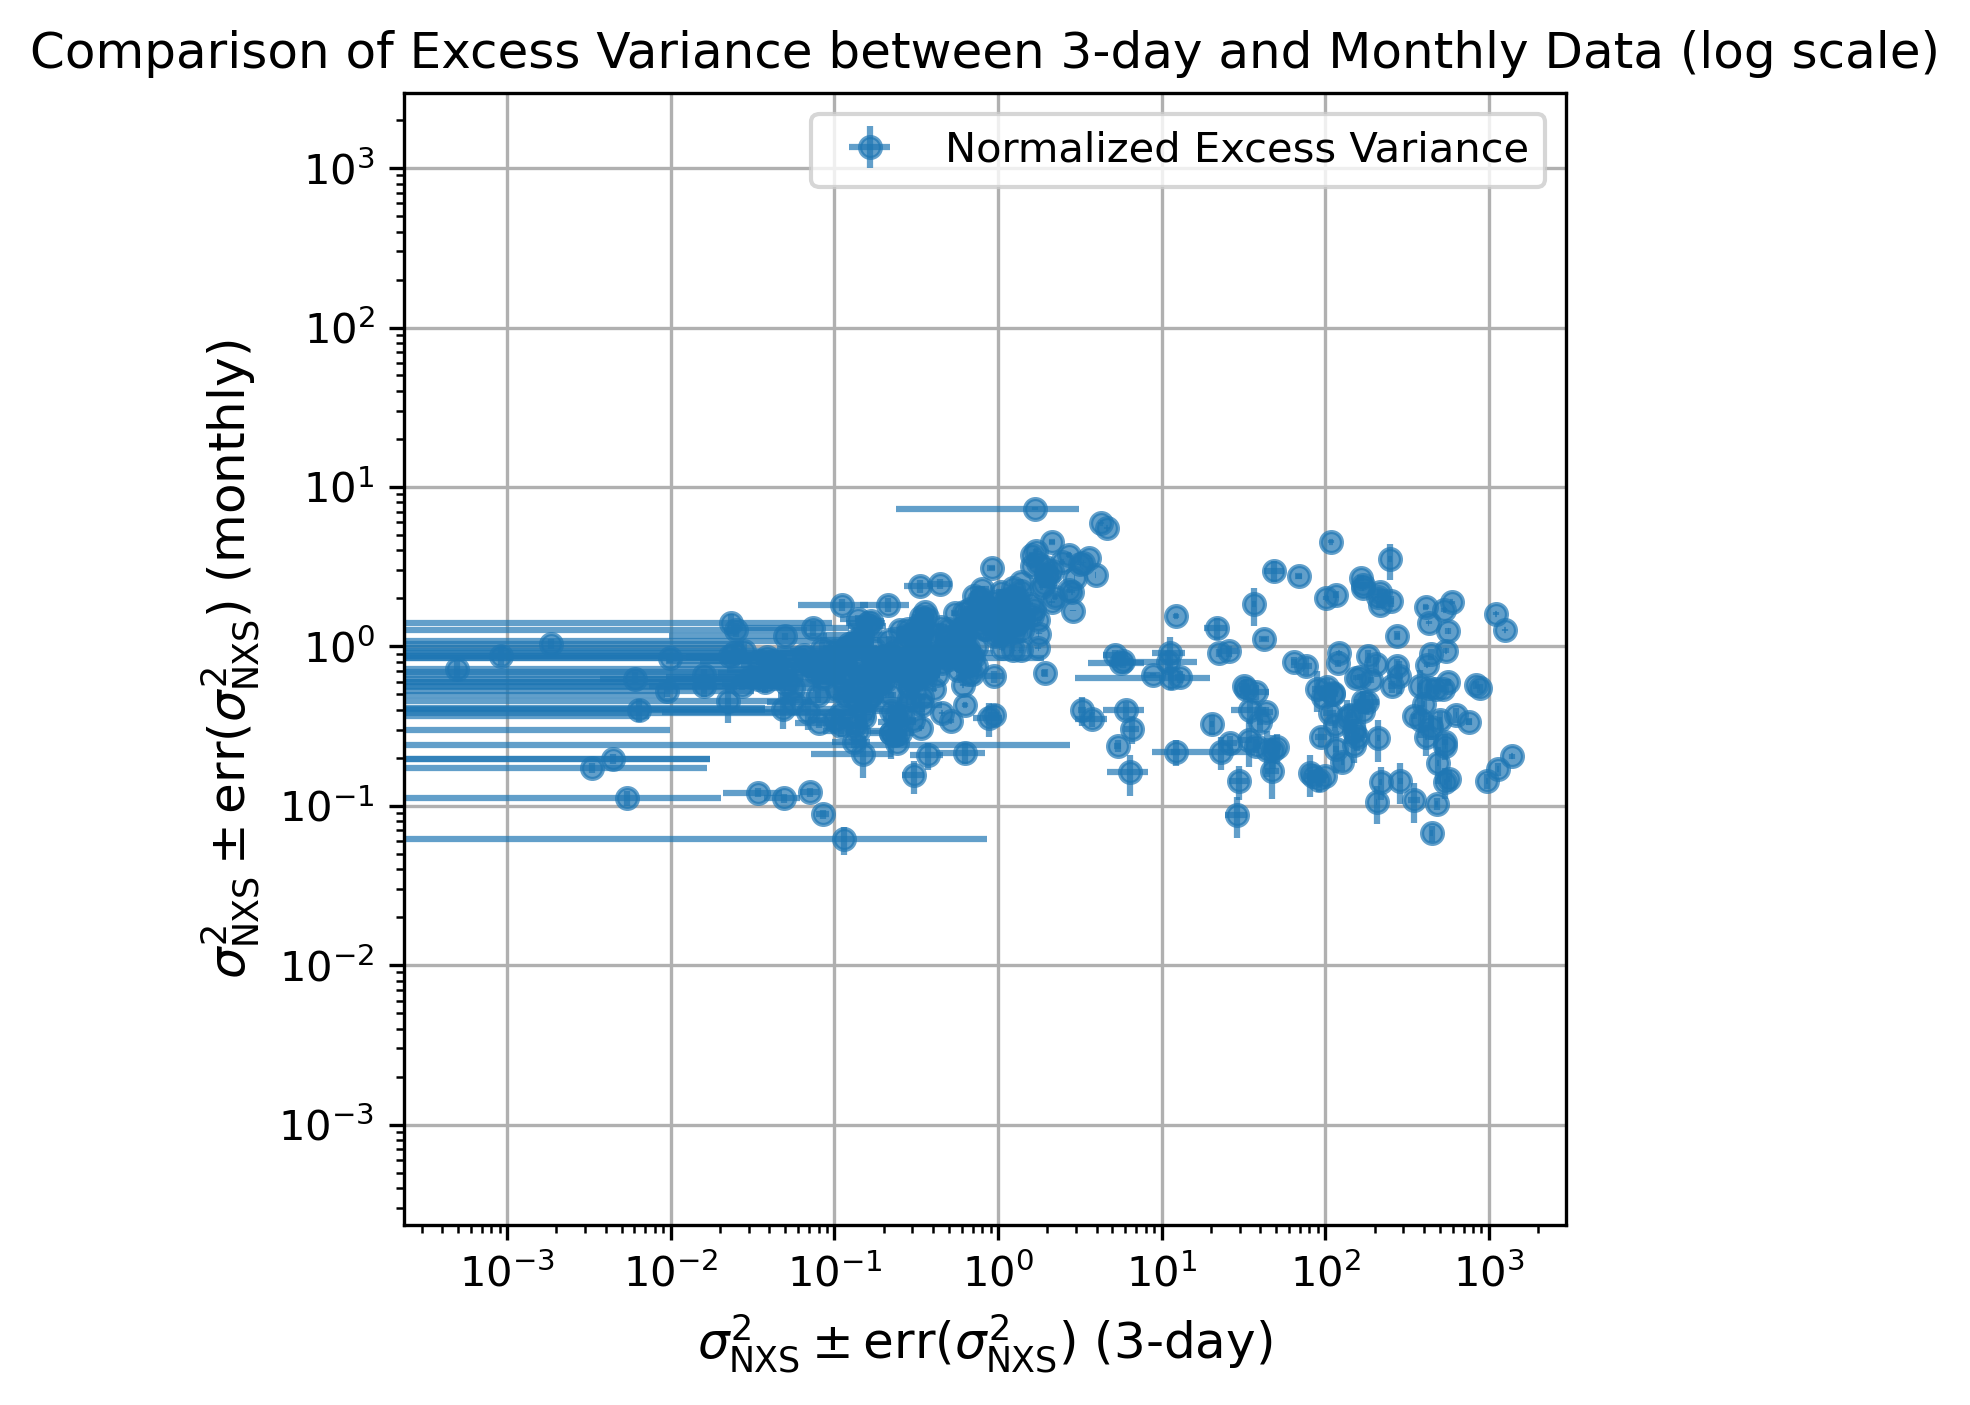

In [50]:
## plot V_NXS(3-day) +/- eV_NXS(3-day) versus V_NXS(month) +/- eV_NXS(month)

plt.figure(figsize=(5,5), dpi=300)

plt.errorbar(selected_table_3days['Norm_Excess_Variance_Estimated'], selected_table_monthly['Norm_Excess_Variance_Estimated'],
             xerr=selected_table_3days['Unc_Norm_Excess_Variance_Estimated'], yerr=selected_table_monthly['Unc_Norm_Excess_Variance_Estimated'],
             fmt='o', markersize=5, alpha=0.7, label='Normalized Excess Variance')

plt.xlabel('$\sigma_{\mathrm{NXS}}^{2} \pm \mathrm{err}(\sigma_{\mathrm{NXS}}^{2})$ (3-day)', fontsize=12)
plt.ylabel('$\sigma_{\mathrm{NXS}}^{2} \pm \mathrm{err}(\sigma_{\mathrm{NXS}}^{2})$ (monthly)', fontsize=12)
plt.title('Comparison of Excess Variance between 3-day and Monthly Data (log scale)', fontsize=12)
plt.legend()

plt.xscale('log')
plt.yscale('log')

plt.ylim(plt.xlim())

plt.grid(True)
plt.show()

/Users/luanareis/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:171: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order, subok=True)


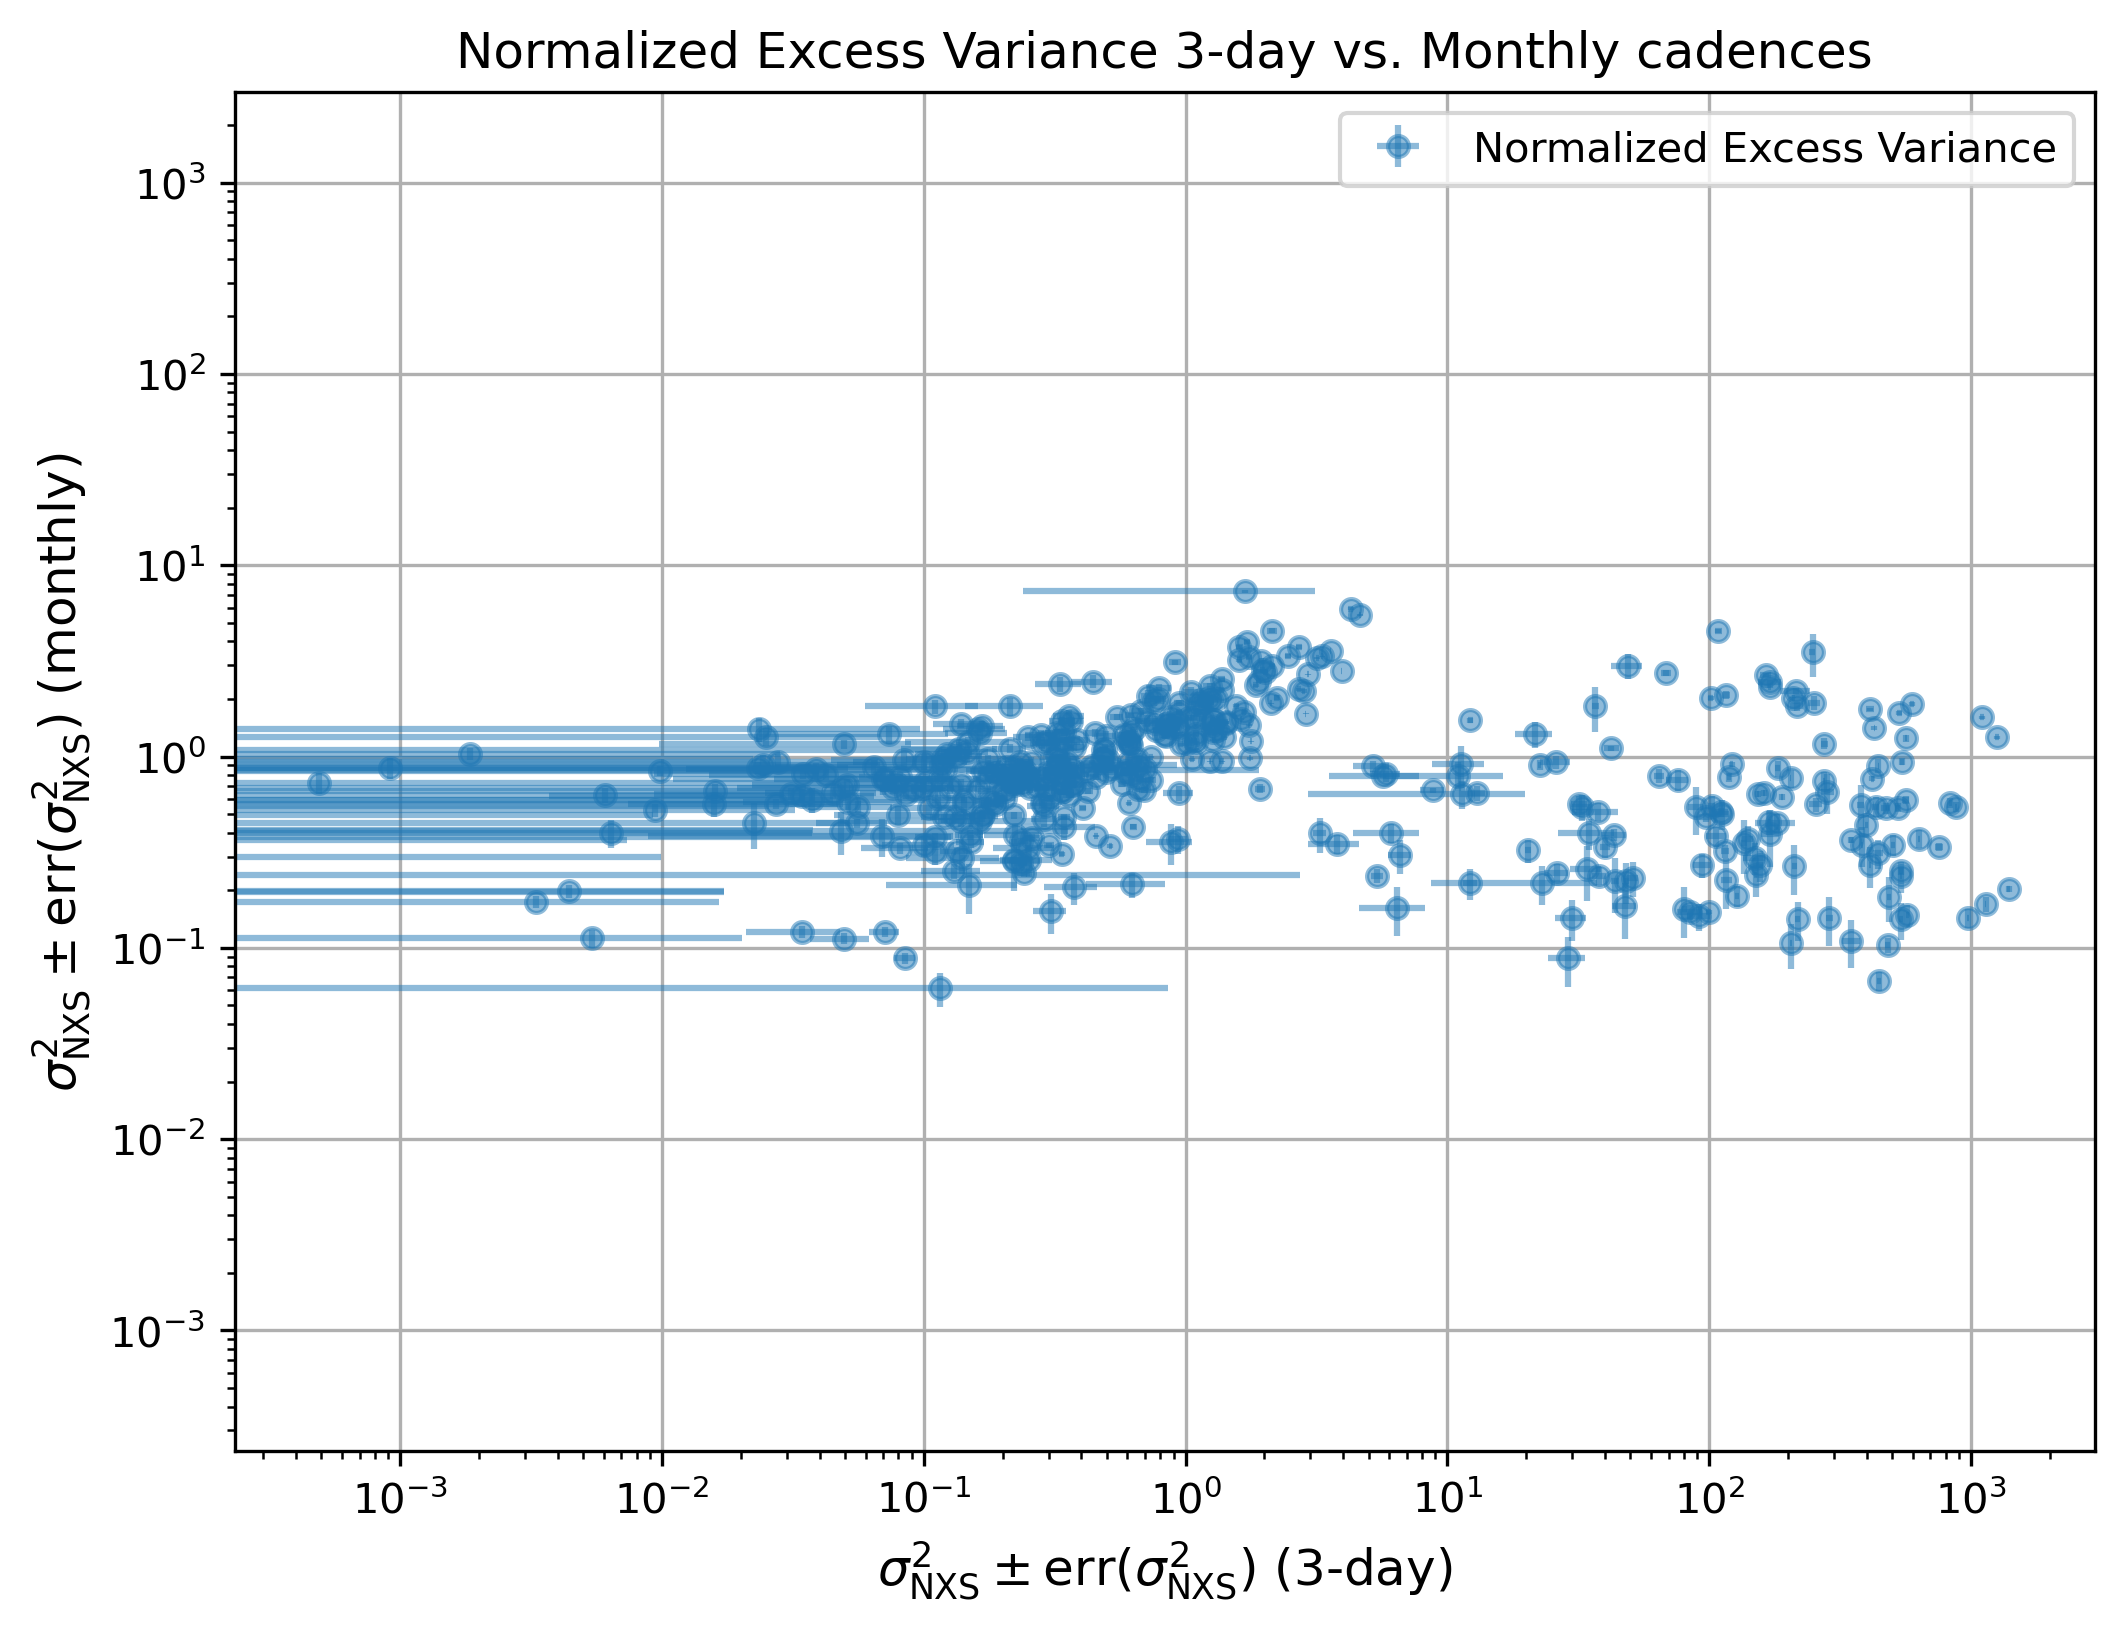

In [51]:
## plot V_NXS(3-day) +/- eV_NXS(3-day) versus V_NXS(month) +/- eV_NXS(month)

plt.figure(figsize=(8,6), dpi=300)

plt.errorbar(selected_table_3days['Norm_Excess_Variance_Estimated'], selected_table_monthly['Norm_Excess_Variance_Estimated'],
             xerr=selected_table_3days['Unc_Norm_Excess_Variance_Estimated'], yerr=selected_table_monthly['Unc_Norm_Excess_Variance_Estimated'],
             fmt='o', markersize=5, alpha=0.5, label='Normalized Excess Variance')

plt.xlabel('$\sigma_{\mathrm{NXS}}^{2} \pm \mathrm{err}(\sigma_{\mathrm{NXS}}^{2})$ (3-day)', fontsize=12)
plt.ylabel('$\sigma_{\mathrm{NXS}}^{2} \pm \mathrm{err}(\sigma_{\mathrm{NXS}}^{2})$ (monthly)', fontsize=12)
plt.title('Normalized Excess Variance 3-day vs. Monthly cadences', fontsize=12)
plt.legend()

plt.xscale('log')
plt.yscale('log')

plt.ylim(plt.xlim())

plt.grid(True)
plt.show()

/Users/luanareis/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:171: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order, subok=True)


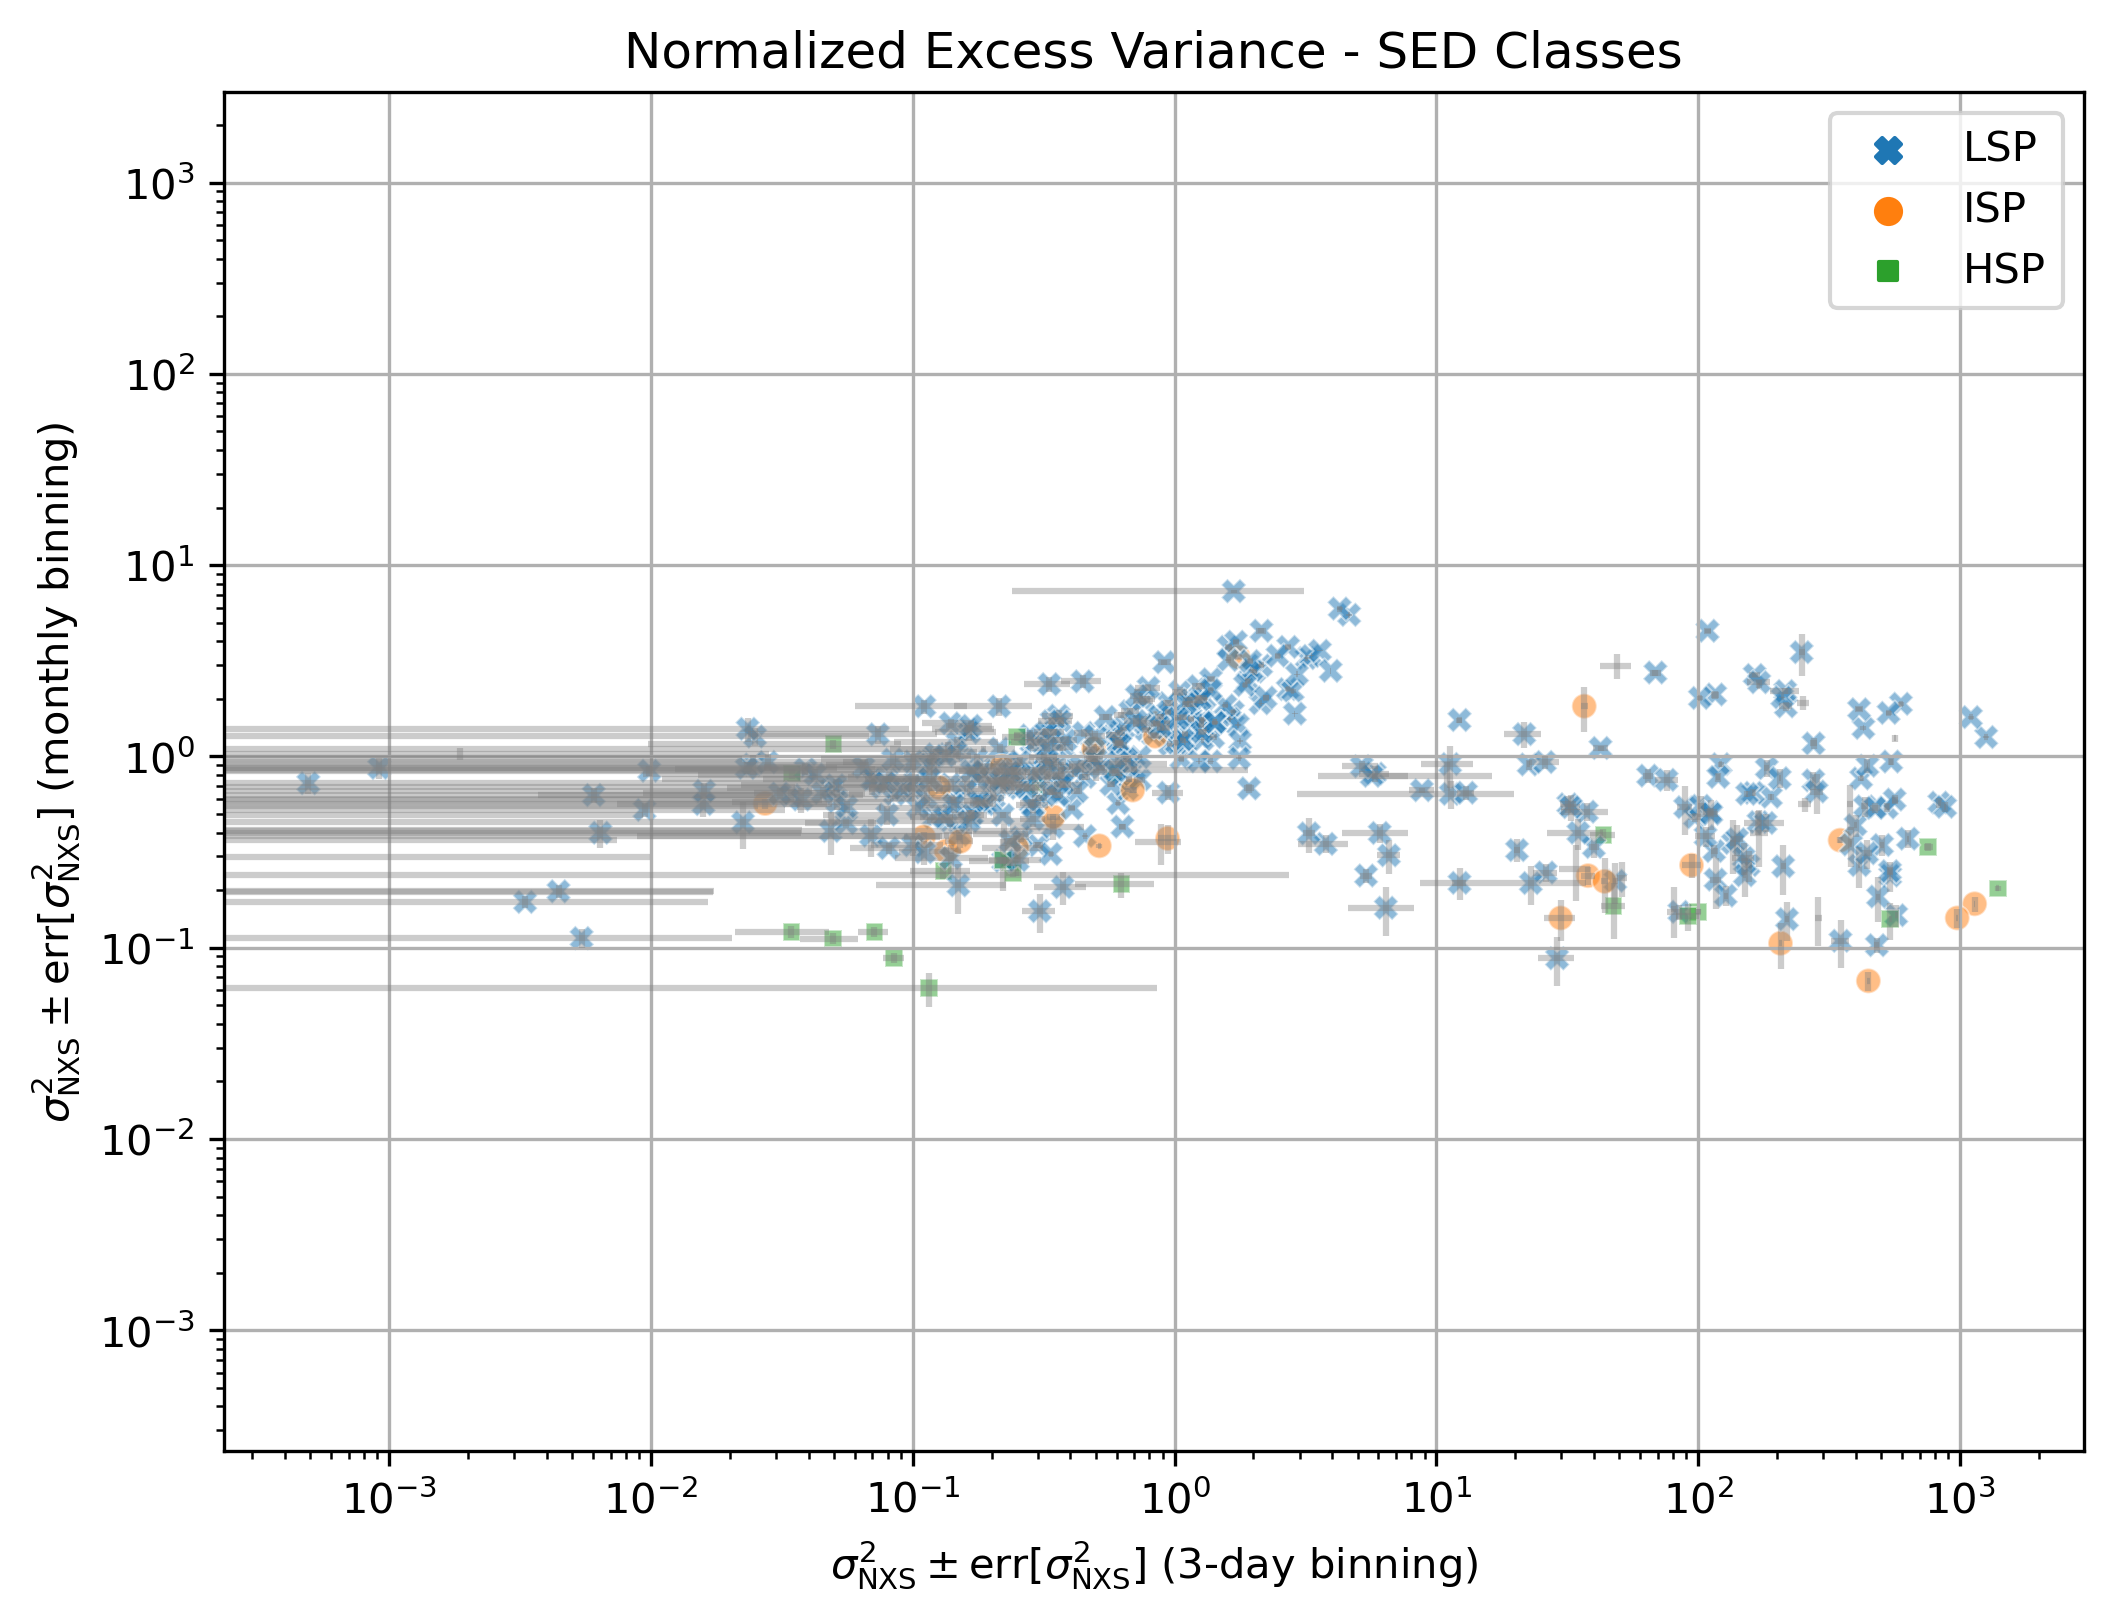

In [52]:
plt.figure(figsize=(8,6), dpi=300)


sns.scatterplot(x=selected_table_3days['Norm_Excess_Variance_Estimated'], 
                y=selected_table_monthly['Norm_Excess_Variance_Estimated'], 
                hue=selected_table_monthly['SED_class'], hue_order=['LSP','ISP','HSP'],
                style=selected_table_monthly['SED_class'], alpha=0.5)

plt.errorbar(selected_table_3days['Norm_Excess_Variance_Estimated'], 
             selected_table_monthly['Norm_Excess_Variance_Estimated'],
             xerr=selected_table_3days['Unc_Norm_Excess_Variance_Estimated'], 
             yerr=selected_table_monthly['Unc_Norm_Excess_Variance_Estimated'],
             fmt='none', ecolor='gray', alpha=0.4)

plt.xscale('log')
plt.yscale('log')

plt.xlabel('$\sigma_{\mathrm{NXS}}^{2} \pm \mathrm{err}[\sigma_{\mathrm{NXS}}^{2}]$ (3-day binning)', fontsize=10)
plt.ylabel('$\sigma_{\mathrm{NXS}}^{2} \pm \mathrm{err}[\sigma_{\mathrm{NXS}}^{2}]$ (monthly binning)', fontsize=10)
plt.title('Normalized Excess Variance - SED Classes', fontsize=12)
plt.legend()

plt.ylim(plt.xlim())

plt.grid(True)
plt.show()


/Users/luanareis/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:171: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order, subok=True)


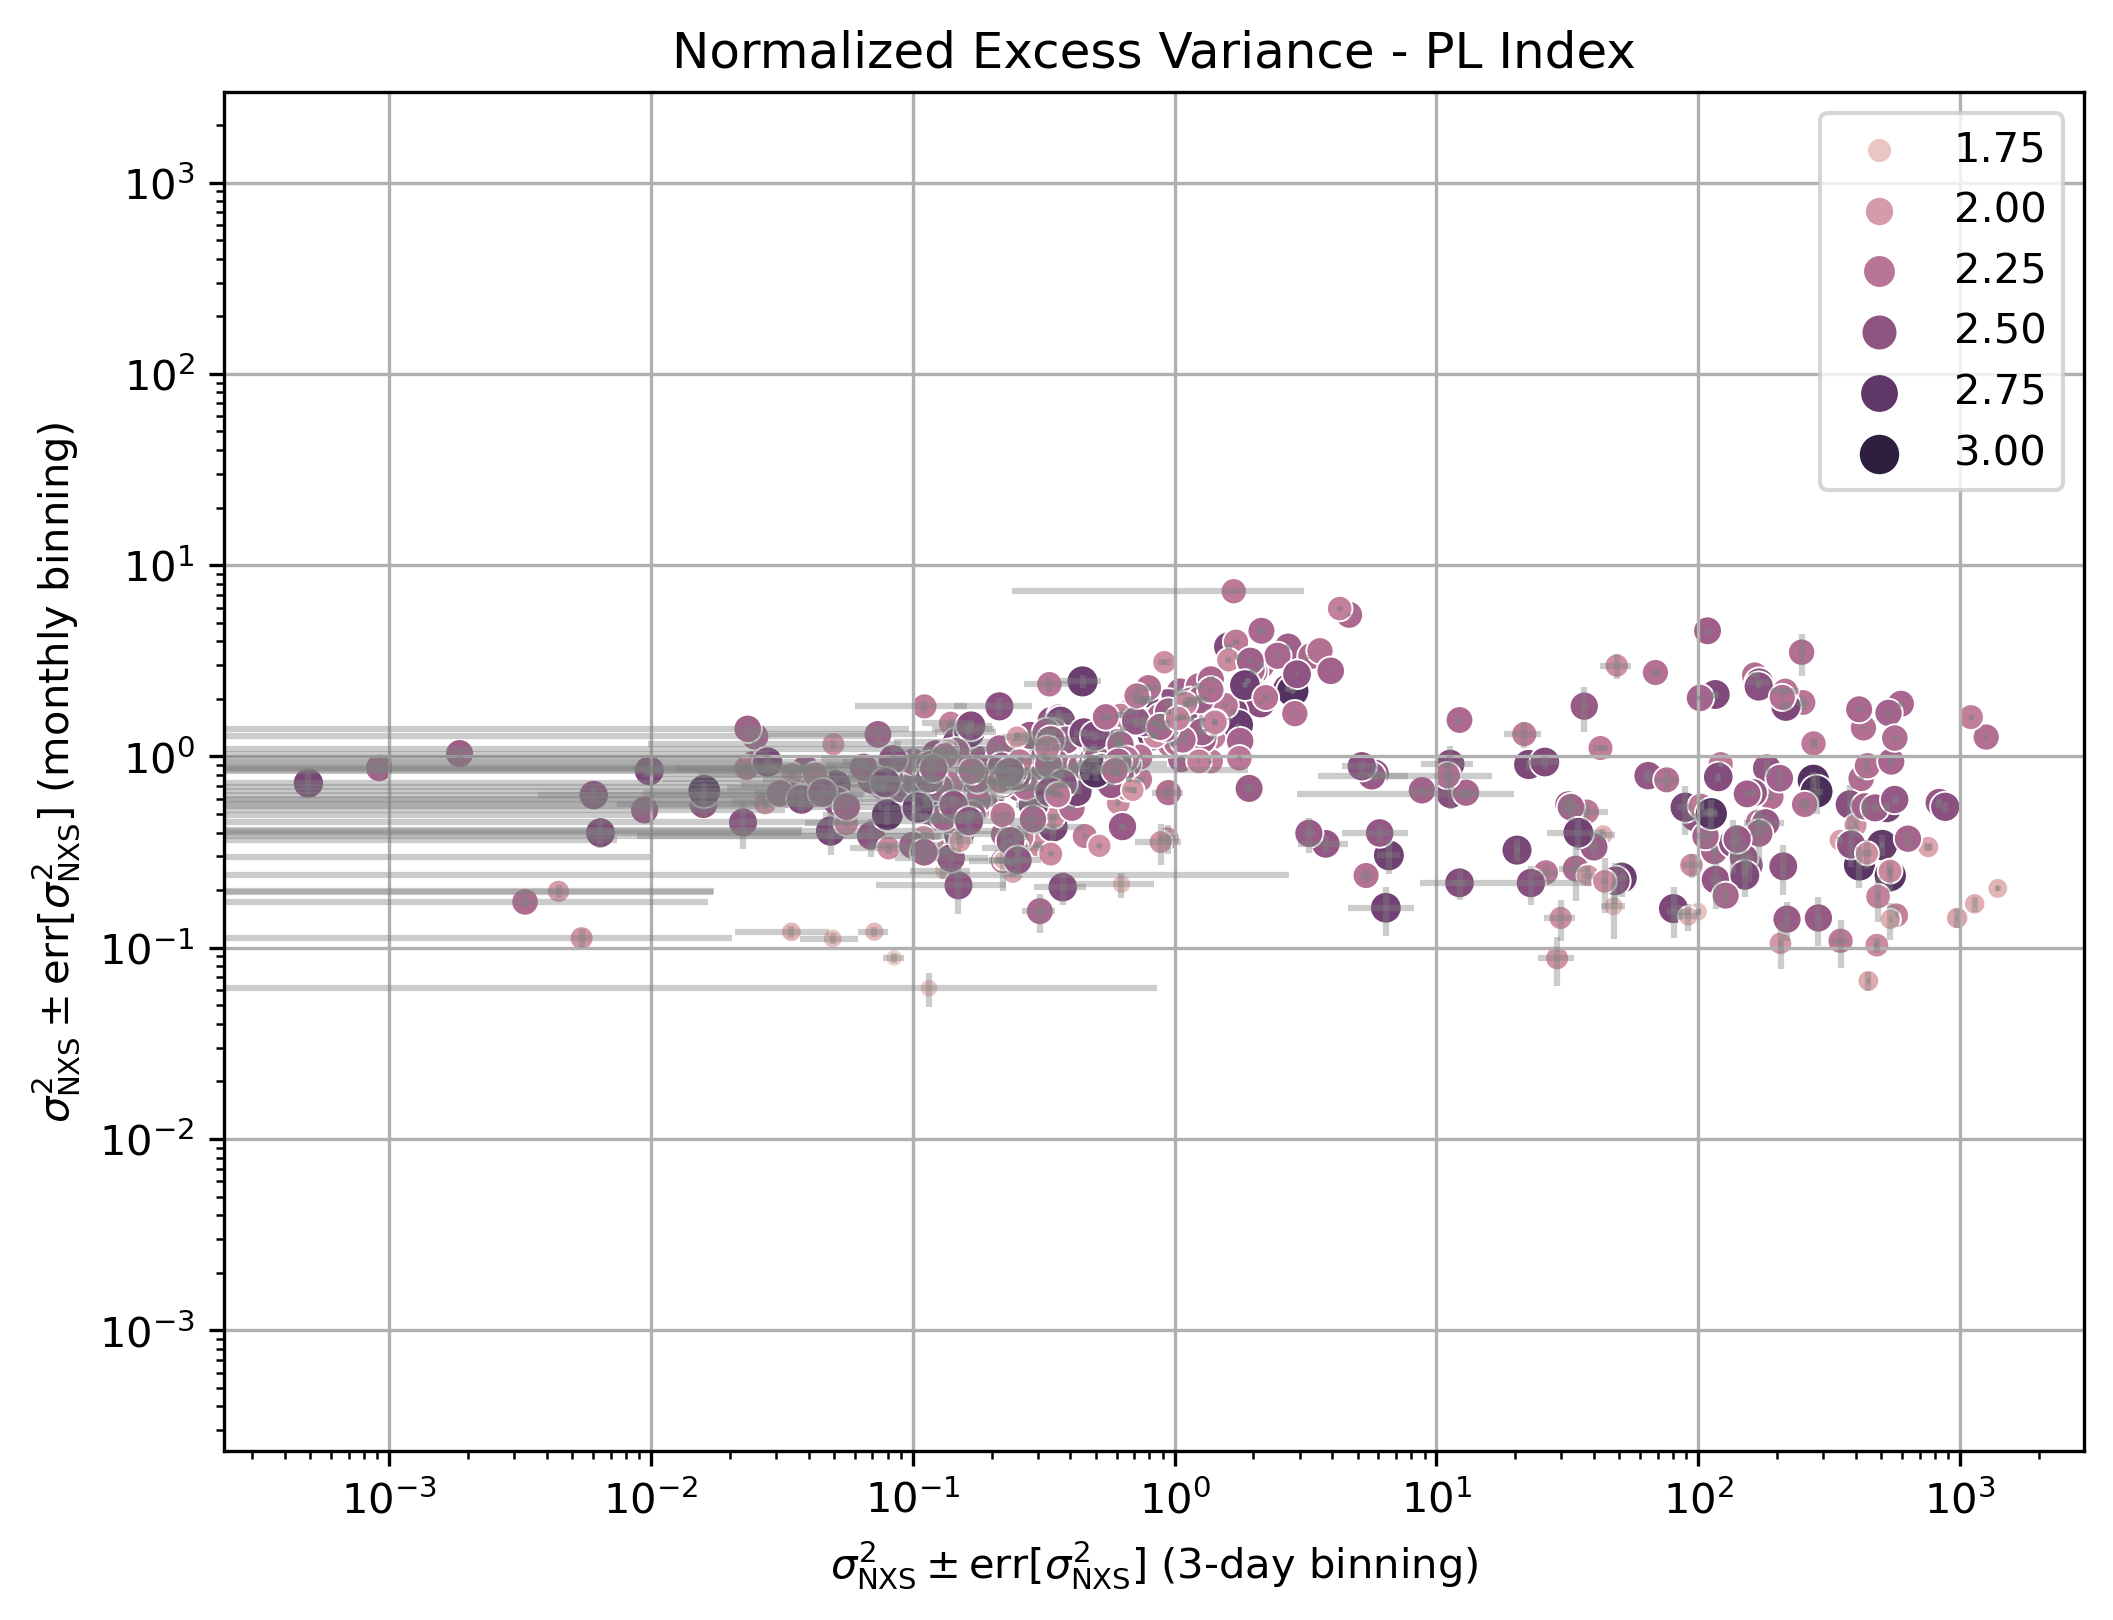

In [53]:
plt.figure(figsize=(8,6), dpi=300)


sns.scatterplot(x=selected_table_3days['Norm_Excess_Variance_Estimated'], 
                y=selected_table_monthly['Norm_Excess_Variance_Estimated'], 
                hue=selected_table_monthly['PL_Index'], size=selected_table_monthly['PL_Index'])

plt.errorbar(selected_table_3days['Norm_Excess_Variance_Estimated'], 
             selected_table_monthly['Norm_Excess_Variance_Estimated'],
             xerr=selected_table_3days['Unc_Norm_Excess_Variance_Estimated'], 
             yerr=selected_table_monthly['Unc_Norm_Excess_Variance_Estimated'],
             fmt='none', ecolor='gray', alpha=0.4)

plt.xscale('log')
plt.yscale('log')

plt.xlabel('$\sigma_{\mathrm{NXS}}^{2} \pm \mathrm{err}[\sigma_{\mathrm{NXS}}^{2}]$ (3-day binning)', fontsize=10)
plt.ylabel('$\sigma_{\mathrm{NXS}}^{2} \pm \mathrm{err}[\sigma_{\mathrm{NXS}}^{2}]$ (monthly binning)', fontsize=10)
plt.title('Normalized Excess Variance - PL Index', fontsize=12)
plt.legend()

plt.ylim(plt.xlim())

plt.grid(True)
plt.show()


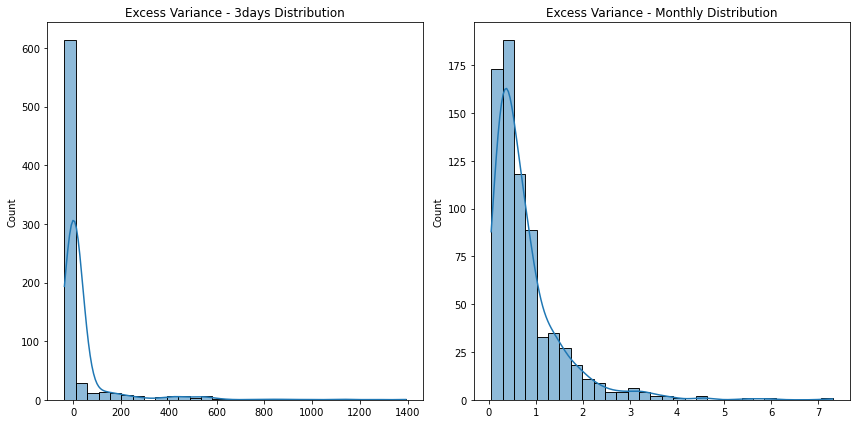

In [54]:
## show the distributions (histograms) of V_NXS(3-day) and V_NXS(month)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

sns.histplot(selected_table_3days['Norm_Excess_Variance_Estimated'], bins=30, kde=True, ax=axes[0])
axes[0].set_title('Excess Variance - 3days Distribution')

sns.histplot(selected_table_monthly['Norm_Excess_Variance_Estimated'], bins=30, kde=True, ax=axes[1])
axes[1].set_title('Excess Variance - Monthly Distribution')

plt.tight_layout()
plt.show()

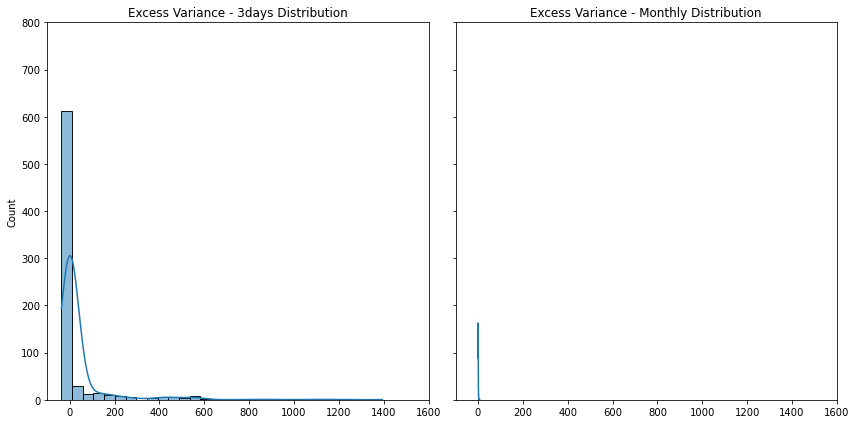

In [55]:
## x and y with same values

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharex=True, sharey=True)

sns.histplot(selected_table_3days['Norm_Excess_Variance_Estimated'], bins=30, kde=True, ax=axes[0])
axes[0].set_title('Excess Variance - 3days Distribution')
axes[0].set_xlim(-100, 1600)
axes[0].set_ylim(0, 800)

sns.histplot(selected_table_monthly['Norm_Excess_Variance_Estimated'], bins=30, kde=True, ax=axes[1])
axes[1].set_title('Excess Variance - Monthly Distribution')

plt.tight_layout()
plt.show()

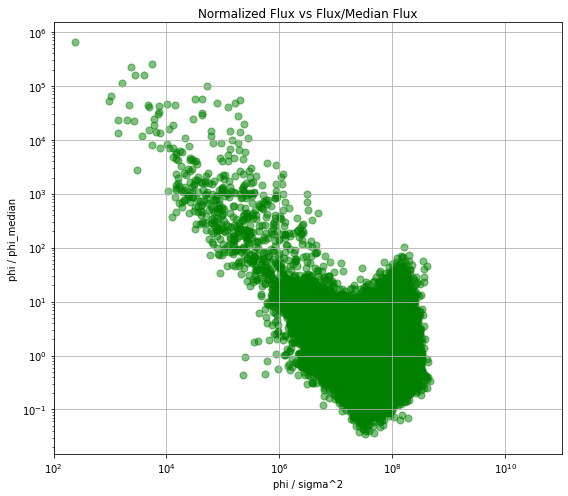

In [97]:
## 3-days

x_axis_all = []
y_axis_all = []


for file_name in lc_3days_file_list:
    
    ## extracting lightcurve parameters from the downloaded .json files
    source_dictionary, source_df = read_json_catalog(file_name, '3-days')
    
    ## removing outliers from the dataframe
    filtered_df = removing_outliers(source_df)
    
    ## select only non-NaN values from the DataFrame for flux and flux_error
    flux_non_nan_values = filtered_df.dropna(subset=['flux'])
    flux_error_non_nan_values = filtered_df.dropna(subset=['flux_error'])

    ## get the indexes (time) of the non-NaN values
    time_flux_non_nan = flux_non_nan_values.index
    time_flux_error_non_nan = flux_error_non_nan_values.index

    ## selected flux points
    selected_flux_values = flux_non_nan_values['flux']
    selected_flux_error_values = flux_error_non_nan_values['flux_error']

    x_axis = selected_flux_values / (selected_flux_error_values**2)
    y_axis = selected_flux_values / np.median(selected_flux_values)
    
    ## append
    x_axis_all.extend(x_axis)
    y_axis_all.extend(y_axis)

    
## Plot
plt.figure(figsize=(8, 7))
plt.scatter(x_axis_all, y_axis_all, alpha=0.5, s=50, color='green')
plt.xscale('log')
plt.yscale('log')
plt.xlim(1e2,1e11)
plt.xlabel('phi / sigma^2')
plt.ylabel('phi / phi_median')
plt.title('Normalized Flux vs Flux/Median Flux')
plt.grid(True)
plt.tight_layout()
plt.show()

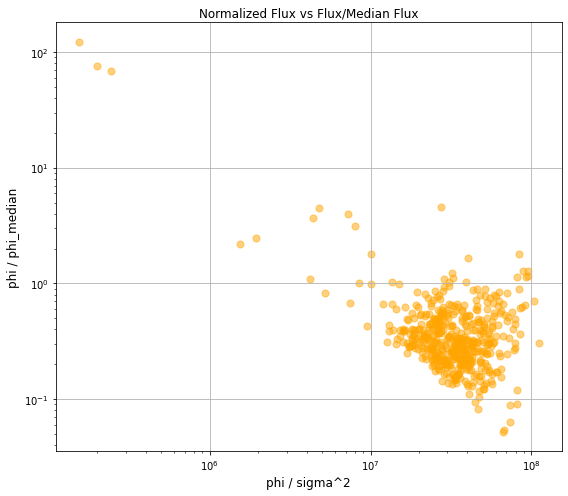

In [57]:
## Testing ONE source

x_axis_all = []
y_axis_all = []

    
## extracting lightcurve parameters from the downloaded .json files
source_dictionary, source_df = read_json_catalog('4FGL+J1858.3-2511.json', '3-days')

## removing outliers from the dataframe
filtered_df = removing_outliers(source_df)

## select only non-NaN values from the DataFrame for flux and flux_error
flux_non_nan_values = filtered_df.dropna(subset=['flux'])
flux_error_non_nan_values = filtered_df.dropna(subset=['flux_error'])

## get the indexes (time) of the non-NaN values
time_flux_non_nan = flux_non_nan_values.index
time_flux_error_non_nan = flux_error_non_nan_values.index

## selected flux points
selected_flux_values = flux_non_nan_values['flux']
selected_flux_error_values = flux_error_non_nan_values['flux_error']

x_axis = selected_flux_values / (selected_flux_error_values**2)
y_axis = selected_flux_values / np.mean(selected_flux_values)

## append
x_axis_all.extend(x_axis)
y_axis_all.extend(y_axis)

    
## Plot
plt.figure(figsize=(8, 7))
plt.scatter(x_axis_all, y_axis_all, alpha=0.5, s=50, color='orange')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('phi / sigma^2', fontsize=12)
plt.ylabel('phi / phi_median', fontsize=12)
plt.title('Normalized Flux vs Flux/Median Flux', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

In [101]:
## 3-days -- flux_error / flux vs. ts

x_axis_all3 = []
y_axis_all3 = []


for file_name in lc_3days_file_list:
    
    ## extracting lightcurve parameters from the downloaded .json files
    source_dictionary, source_df = read_json_catalog(file_name, '3-days')
    
    ## removing outliers from the dataframe
    filtered_df = removing_outliers(source_df)
#     filtered_df = source_df

    ## reset index
    filtered_df.reset_index(inplace=True)
    
    ## select only non-NaN values from the DataFrame for flux and flux_error
    non_nan_values = filtered_df.dropna(subset=['flux'])
    
#     print(filtered_df)


    ## get the indexes (time) of the non-NaN values
    time_fit_non_nan = non_nan_values['time_fit_convergence'].values

    ## selected flux points
    selected_flux_values = non_nan_values['flux'].values
    selected_flux_error_values = non_nan_values['flux_error'].values
    selected_ts_values = non_nan_values['values_ts'].values
    
#     print(selected_ts_values)

    x_axis = selected_ts_values
    y_axis = selected_flux_error_values / selected_flux_values
#     x_axis = selected_flux_values / selected_flux_error_values
    
    ## append
    x_axis_all3.extend(x_axis)
    y_axis_all3.extend(y_axis)


In [102]:
x_axis_all3_array = np.array(x_axis_all3)
y_axis_all3_array = np.array(y_axis_all3)

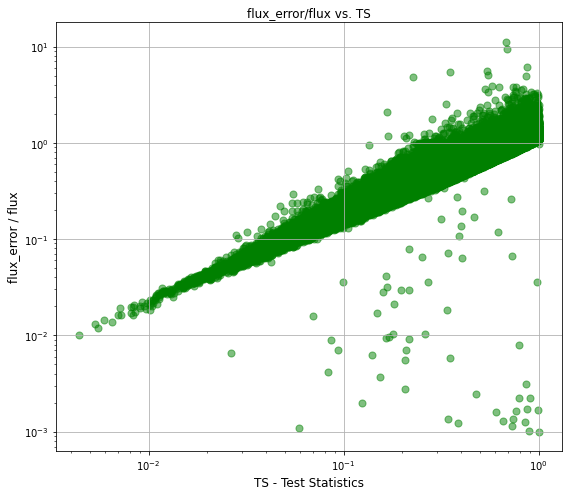

In [103]:
## Plot TS

plt.figure(figsize=(8, 7))
plt.scatter(1/np.sqrt(x_axis_all3_array), y_axis_all3_array, alpha=0.5, s=50, color='green')

plt.xscale('log')
plt.yscale('log')

plt.xlabel('TS - Test Statistics', fontsize=12)
plt.ylabel('flux_error / flux', fontsize=12)
plt.title('flux_error/flux vs. TS', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

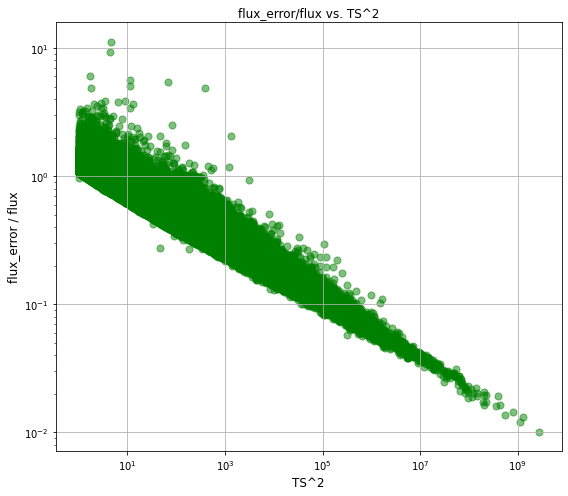

In [96]:
## Plot TS^2

plt.figure(figsize=(8, 7))
plt.scatter(x_axis_all3_array**2, y_axis_all3_array, alpha=0.5, s=50, color='green')

plt.xscale('log')
plt.yscale('log')

plt.xlabel('TS^2', fontsize=12)
plt.ylabel('flux_error / flux', fontsize=12)
plt.title('flux_error/flux vs. TS^2', fontsize=12)

plt.grid(True)
plt.tight_layout()
plt.show()

In [62]:
def func_threshold(x):
    
    return np.exp(-0.5 - np.log10(x))

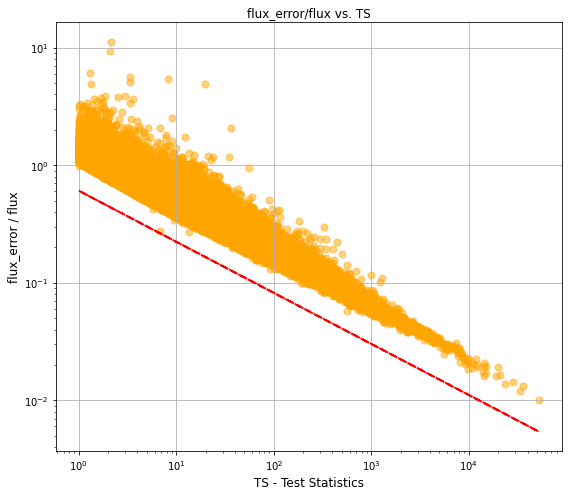

In [63]:
## Plot TS

plt.figure(figsize=(8, 7))
plt.scatter(x_axis_all3, y_axis_all3, alpha=0.5, s=50, color='orange')

threshold_values = func_threshold(x_axis_all3_array)  # Calculate the threshold values for plotting
plt.plot(x_axis_all3_array, threshold_values, color='red', linestyle='--', linewidth=2, label='Threshold Curve')

plt.xscale('log')
plt.yscale('log')

plt.xlabel('TS - Test Statistics', fontsize=12)
plt.ylabel('flux_error / flux', fontsize=12)
plt.title('flux_error/flux vs. TS', fontsize=12)

plt.grid(True)
plt.tight_layout()
plt.show()

In [64]:
outliers = []
filtered_data = []

for i, (x, y) in enumerate(zip(x_axis_all3_array, y_axis_all3_array)):
    
    min_threshold = func_threshold(x)
    
    if y >= min_threshold:
        filtered_data.append((x, y))
        
    else:
        outliers.append(i)  # Track the index of outliers

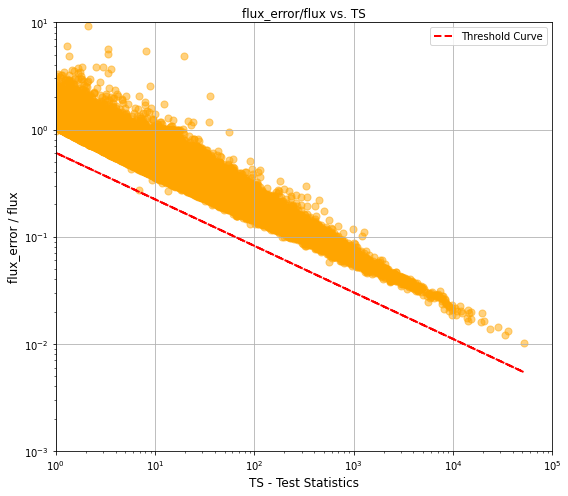

In [65]:
# Plot the filtered data

x_filtered, y_filtered = zip(*filtered_data)

plt.figure(figsize=(8, 7))
plt.scatter(x_filtered, y_filtered, alpha=0.5, s=50, color='orange')

plt.xscale('log')
plt.yscale('log')

plt.xlim(1e0,1e5)
plt.ylim(1e-3,1e1)

plt.xlabel('TS - Test Statistics', fontsize=12)
plt.ylabel('flux_error / flux', fontsize=12)
plt.title('flux_error/flux vs. TS', fontsize=12)

plt.grid(True)


threshold_values = func_threshold(x_axis_all3_array)  # Calculate the threshold values for plotting
plt.plot(x_axis_all3_array, threshold_values, color='red', linestyle='--', linewidth=2, label='Threshold Curve')
plt.legend()

plt.tight_layout()
plt.show()

In [66]:
names = selected_table_monthly['Source_Name']

v_nxs_3days = selected_table_3days['Norm_Excess_Variance_Estimated']
unc_v_nxs_3days = selected_table_3days['Unc_Norm_Excess_Variance_Estimated']

v_nxs_monthly = selected_table_monthly['Norm_Excess_Variance_Estimated']
unc_v_nxs_monthly = selected_table_monthly['Unc_Norm_Excess_Variance_Estimated']

classes = selected_table_monthly['CLASS']
classes_SED = selected_table_monthly['SED_class']

In [67]:
def get_flux(source_name):
    
    ## extracting lightcurve parameters from the downloaded .json files
    source_dictionary, source_df = read_json_catalog(f'4FGL+{source_name}.json', '3-days')
    
    ## removing outliers from the dataframe
    filtered_df = removing_outliers(source_df)
    
    ## select only non-NaN values from the DataFrame for flux and flux_error
    flux_non_nan_values = filtered_df.dropna(subset=['flux'])
    flux_error_non_nan_values = filtered_df.dropna(subset=['flux_error'])

    ## get the indexes (time) of the non-NaN values
    time_flux_non_nan = flux_non_nan_values.index
    time_flux_error_non_nan = flux_error_non_nan_values.index

    ## selected flux points
    selected_flux_values = flux_non_nan_values['flux']
    selected_flux_error_values = flux_error_non_nan_values['flux_error']

    ## spectrum flux (?)
    index = df_agn_pop_4lac_dr3[df_agn_pop_4lac_dr3['Source_Name'] == source_name].index[0]
    spectrum_flux = df_agn_pop_4lac_dr3.loc[index, 'Spectrum_Flux_Estimated']

    
    return time_flux_non_nan, selected_flux_values, spectrum_flux

/Users/luanareis/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:171: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order, subok=True)


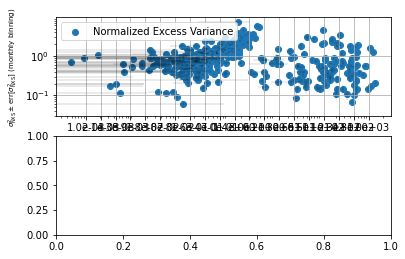

In [68]:
# %matplotlib qt

###### UNCOMMENT THE LINE ABOVE FOR AN INTERACTIVE PLOT


import mplcursors


fig, axs = plt.subplots(2, 1)

# fig, axs = plt.subplots(2, 1, figsize=(15, 10), dpi=300)

# Main plot
axs[0].scatter(v_nxs_3days, v_nxs_monthly, label='Normalized Excess Variance')
axs[0].errorbar(v_nxs_3days, v_nxs_monthly, xerr = unc_v_nxs_3days, yerr = unc_v_nxs_monthly, ls='none', ecolor = 'black', alpha = 0.1)

axs[0].set_xscale('log')
axs[0].set_yscale('log')

axs[0].set_xlabel('$\sigma_{\mathrm{NXS}}^{2} \pm \mathrm{err}[\sigma_{\mathrm{NXS}}^{2}]$ (3-day binning)', fontsize=7)
axs[0].set_ylabel('$\sigma_{\mathrm{NXS}}^{2} \pm \mathrm{err}[\sigma_{\mathrm{NXS}}^{2}]$ (monthly binning)', fontsize=7)

axs[0].grid()
axs[0].legend()

x_ticks = np.logspace(-3, 3, num=20, base=10)
x_tick_labels = [f'{tick:.1e}' for tick in x_ticks]
axs[0].set_xticks(x_ticks)
axs[0].set_xticklabels(x_tick_labels)

# Create a cursor for annotations
cursor = mplcursors.cursor(hover=True)

# cursor.connect("add", lambda sel: sel.annotation.draggable(True))
cursor.connect("add", lambda sel: sel.annotation.set_backgroundcolor('pink'))

# Format the annotation displayed when hovering over a point
@cursor.connect("add")
def on_hover(sel):
    index = sel.target.index
    x = sel.target[0]
    y = sel.target[1]
    source_name = names[index]
    source_class = classes[index]
    source_SED_class = classes_SED[index]
    sel.annotation.set_text(f"Source: {source_name}\nV_NXS (3days): {x:.2f}\nV_NXS (monthly): {y:.2f}\n\nClass: {source_class}\nSED Class: {source_SED_class}")
    
#     sel.annotation.set_alpha(1.0) # no transparency
    
    # Clear the LC subplot
    axs[1].cla()
    
    time_flux_non_nan, selected_flux_values, spectrum_flux = get_flux(source_name)
    
    # ## Converting time from MET to UTC
    # time_UTC = convert_MET_UTC(data_dict['time'])
    # time_error_UTC = convert_MET_UTC(data_dict['time_error'])
    # time_upper_lim_UTC = convert_MET_UTC(data_dict['time_upper_lim'])

    ## Flux
    axs[1].plot(time_flux_non_nan, selected_flux_values, '.', markersize=10, label='Flux Points')
    axs[1].plot(time_flux_non_nan, selected_flux_values, linewidth=0.4, color='black')
    
    ## spectrum_flux
    axs[1].hlines(y=np.average(selected_flux_values), xmin=np.min(time), xmax=np.max(time), linewidth=3, linestyles='-.', color='blue', label='Average LC Flux Points')
    axs[1].hlines(y=spectrum_flux, xmin=np.min(time), xmax=np.max(time), linewidth=3, linestyles='--', color='red', label='Flux from Spectrum')
    
    
    ## Upper Limits
    # axs[1].plot(time_upper_lim_UTC, data_dict['flux_upper_lim'], 'v', color='gray', markersize=3, alpha=0.45, label='Upper Limits')

    ## Error_bar
    # axs[1].errorbar(time_UTC, data_dict['flux'], yerr=data_dict['flux_high_error']-data_dict['flux'], linewidth=0.2, color='black', alpha=0.9)
    # axs[1].errorbar(time_UTC, data_dict['flux'], yerr=data_dict['flux']-data_dict['flux_low_error'], linewidth=0.2, color='black', alpha=0.9)
    
    axs[1].set_title(f'Lightcurve for {source_name}', fontsize=7)
    axs[1].set_xlabel('Time (MET)')
    axs[1].set_ylabel('Flux (0.1-100 GeV ph $cm^{-2}$ $s^{-1}$)')
    
    axs[1].set_ylim(0, np.max(selected_flux_values))
    
plt.show()

In [69]:
%matplotlib inline

In [70]:
## approaches to handle:

# pesos p pontos de fluxo, e menor/ maior pra frequência de aparições de fluxo muito maior que o típico

# usar spectrum flux (plotar SED junto) como normalização/ média ?


# mediana ?

# media, desvio padrao da media, propagacao de incertezas




## estatistica robusta a outliers: metodo de bootstrap, método RANSAC - random sample consensus


# classes diferentes devem concordar dentro da mesma barra de incerteza

In [71]:
## análise pre e pos alteração - ver resultado de cada implementação

In [72]:
## RobustScaler, KernelCenterer ? sklearn.preprocessing

In [73]:
selected_table_3days

Source_Name,RAJ2000,DEJ2000,Redshift,SpectrumType,Pivot_Energy,PL_Flux_Density,PL_Index,LP_Flux_Density,LP_Index,LP_beta,CLASS,SED_class,Variability_Index,Frac_Variability,Unc_Frac_Variability,Flux1000,Unc_Flux1000,Spectrum_Flux_Estimated,Norm_Excess_Variance_Estimated,Unc_Norm_Excess_Variance_Estimated,Frac_Variability_Estimated,Unc_Frac_Variability_Estimated
str13,float32,float32,float64,str11,float32,float32,float32,float32,float32,float32,str5,str3,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64
J0001.5+2113,0.3815,21.2183,1.106,LogParabola,329.77374,4.683598e-11,2.65406,5.3715615e-11,2.5141594,0.15931939,fsrq,ISP,1910.9358,0.9961379,0.21347848,1.3473536e-09,6.172809e-11,6.391698902983224e-08,0.8557497594793069,0.03129175151947005,0.925067435098278,0.016913227259019042
J0004.3+4614,1.0757,46.2427,1.81,LogParabola,683.0358,1.5384192e-12,2.5879583,1.7702658e-12,2.490068,0.13974935,fsrq,LSP,139.03676,1.0162235,0.2342373,3.8481487e-10,4.1954978e-11,1.0867870933627991e-08,-0.39444602338960677,--,0.0,0.1
J0004.4-4737,1.1091,-47.6233,0.88,PowerLaw,848.0162,8.389526e-13,2.4382217,9.096001e-13,2.393472,0.07083268,fsrq,LSP,153.28648,0.82349813,0.18814608,3.898786e-10,3.2763084e-11,1.0707918289380977e-08,-0.3358342904911222,--,0.0,0.1
J0010.6+2043,2.6502,20.7332,0.6,PowerLaw,1318.4822,1.0727631e-13,2.3900635,1.1624264e-13,2.3289845,0.07038872,fsrq,LSP,30.502176,0.82655686,0.2866108,1.492397e-10,3.018916e-11,3.0114394507446147e-09,0.024407506691349185,0.04366627344426922,0.15622902000380462,0.13975083964299917
J0010.6-3025,2.6675,-30.4258,1.19,LogParabola,606.61017,2.2436983e-12,2.4249508,2.5821133e-12,2.2681289,0.15624313,fsrq,LSP,168.7764,0.8408478,0.1900444,4.989193e-10,4.080262e-11,9.545340735816214e-09,-0.198199818513718,0.0244912310229562,0.0,0.1
J0011.4+0057,2.8551,0.9646,1.492,LogParabola,757.1697,1.7565124e-12,2.353539,1.8841597e-12,2.2449186,0.08350547,fsrq,LSP,231.06699,0.9843933,0.2190029,7.1480244e-10,5.3551368e-11,1.1995542883639901e-08,0.3251281518301798,0.04868339944598688,0.5702000980622327,0.042689750152124215
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
J2336.6-4115,354.1636,-41.2579,1.406,LogParabola,807.90344,1.5211742e-12,2.3462372,1.6937586e-12,2.2487242,0.110323265,fsrq,LSP,161.60208,0.734942,0.16730464,7.259474e-10,4.7130997e-11,1.1694108859410555e-08,-0.0750099720954692,0.04836073407844914,0.0,0.1
J2338.0-0230,354.5085,-2.5106,1.071,PowerLaw,800.7169,2.0730813e-12,2.4845111,2.1689274e-12,2.4632387,0.039221,fsrq,LSP,136.03596,0.57845163,0.13412176,8.0339896e-10,5.138538e-11,2.4540236942974496e-08,0.25169587857910325,0.05600064261375527,0.5016930122884943,0.05581166295131951


In [74]:
selected_table_monthly

Source_Name,RAJ2000,DEJ2000,Redshift,SpectrumType,Pivot_Energy,PL_Flux_Density,PL_Index,LP_Flux_Density,LP_Index,LP_beta,CLASS,SED_class,Variability_Index,Frac_Variability,Unc_Frac_Variability,Flux1000,Unc_Flux1000,Spectrum_Flux_Estimated,Norm_Excess_Variance_Estimated,Unc_Norm_Excess_Variance_Estimated,Frac_Variability_Estimated,Unc_Frac_Variability_Estimated
str13,float32,float32,float64,str11,float32,float32,float32,float32,float32,float32,str5,str3,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64
J0001.5+2113,0.3815,21.2183,1.106,LogParabola,329.77374,4.683598e-11,2.65406,5.3715615e-11,2.5141594,0.15931939,fsrq,ISP,1910.9358,0.9961379,0.21347848,1.3473536e-09,6.172809e-11,6.391698902983224e-08,1.4958192113519022,0.044791196049851,1.2230368806180385,0.018311465810915126
J0004.3+4614,1.0757,46.2427,1.81,LogParabola,683.0358,1.5384192e-12,2.5879583,1.7702658e-12,2.490068,0.13974935,fsrq,LSP,139.03676,1.0162235,0.2342373,3.8481487e-10,4.1954978e-11,1.0867870933627991e-08,0.3104431084417637,0.08426496692829298,0.5571742173160597,0.07561814986181718
J0004.4-4737,1.1091,-47.6233,0.88,PowerLaw,848.0162,8.389526e-13,2.4382217,9.096001e-13,2.393472,0.07083268,fsrq,LSP,153.28648,0.82349813,0.18814608,3.898786e-10,3.2763084e-11,1.0707918289380977e-08,0.30583671743757407,0.06589533476347806,0.5530250604064648,0.05957716881315108
J0010.6+2043,2.6502,20.7332,0.6,PowerLaw,1318.4822,1.0727631e-13,2.3900635,1.1624264e-13,2.3289845,0.07038872,fsrq,LSP,30.502176,0.82655686,0.2866108,1.492397e-10,3.018916e-11,3.0114394507446147e-09,0.9064447029931038,0.11141700306093512,0.9520738957628782,0.05851279168391591
J0010.6-3025,2.6675,-30.4258,1.19,LogParabola,606.61017,2.2436983e-12,2.4249508,2.5821133e-12,2.2681289,0.15624313,fsrq,LSP,168.7764,0.8408478,0.1900444,4.989193e-10,4.080262e-11,9.545340735816214e-09,0.387901890119994,0.06121211287975822,0.6228177021568944,0.049141275743907996
J0011.4+0057,2.8551,0.9646,1.492,LogParabola,757.1697,1.7565124e-12,2.353539,1.8841597e-12,2.2449186,0.08350547,fsrq,LSP,231.06699,0.9843933,0.2190029,7.1480244e-10,5.3551368e-11,1.1995542883639901e-08,0.7920932758926467,0.06977260705632327,0.8899962224035822,0.039198260228504554
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
J2336.6-4115,354.1636,-41.2579,1.406,LogParabola,807.90344,1.5211742e-12,2.3462372,1.6937586e-12,2.2487242,0.110323265,fsrq,LSP,161.60208,0.734942,0.16730464,7.259474e-10,4.7130997e-11,1.1694108859410555e-08,0.5112691688832988,0.08530611893795802,0.7150308866638551,0.05965205177078001
J2338.0-0230,354.5085,-2.5106,1.071,PowerLaw,800.7169,2.0730813e-12,2.4845111,2.1689274e-12,2.4632387,0.039221,fsrq,LSP,136.03596,0.57845163,0.13412176,8.0339896e-10,5.138538e-11,2.4540236942974496e-08,0.28622504368425566,0.05039436078050223,0.5350000408264056,0.0470975298456603


In [75]:
selected_table_3days['Norm_Excess_Variance_Estimated']
selected_table_3days['Spectrum_Flux_Estimated']

6.391698902983224e-08
1.0867870933627991e-08
1.0707918289380977e-08
3.0114394507446147e-09
9.545340735816214e-09
1.1995542883639901e-08
2.0704692135185972e-08
2.1430295929193944e-08
4.062915812609721e-09
...
6.113230135464708e-09


/Users/luanareis/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:171: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order, subok=True)


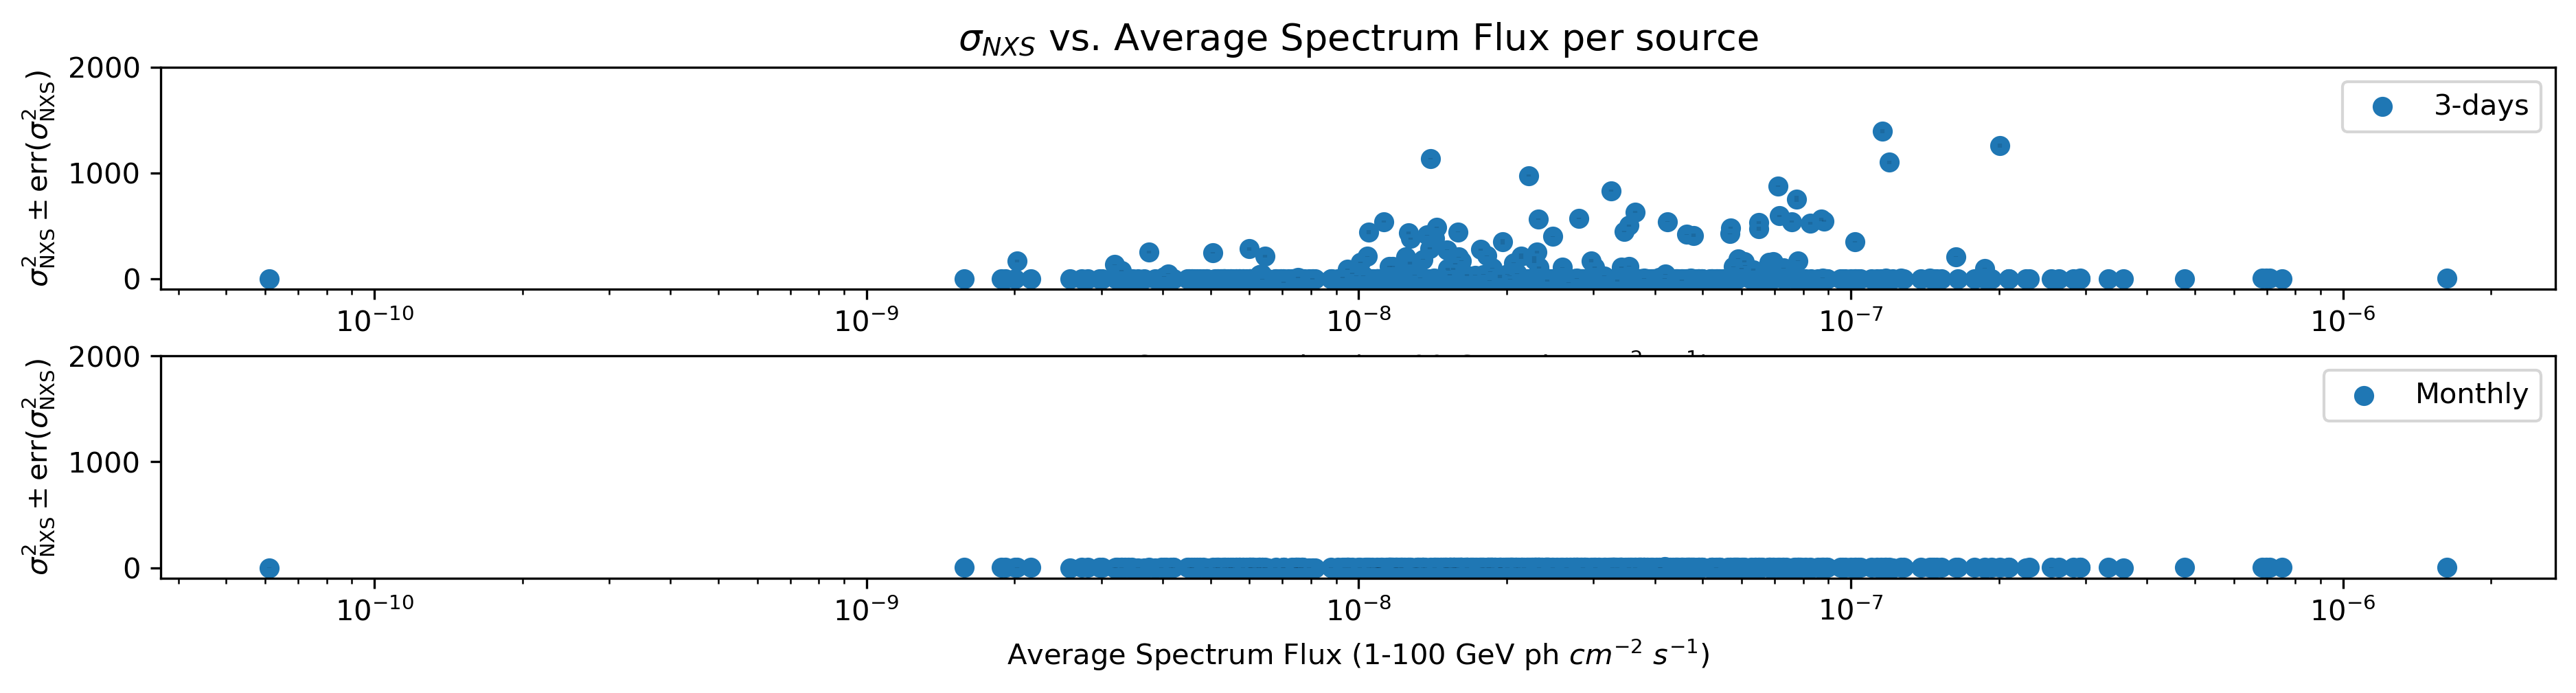

In [76]:
grid = plt.GridSpec(4, 1, wspace=0.4, hspace=0.3)

plt.figure(figsize=(15,7), dpi=300)


plt.subplot(grid[0, 0])

plt.scatter(selected_table_3days['Spectrum_Flux_Estimated'], selected_table_3days['Norm_Excess_Variance_Estimated'], label = '3-days')
plt.errorbar(selected_table_3days['Spectrum_Flux_Estimated'], selected_table_3days['Norm_Excess_Variance_Estimated'], yerr = selected_table_3days['Unc_Norm_Excess_Variance_Estimated'], xerr = None, ls='none', ecolor = 'black', alpha = 0.1) 

plt.xscale('log')
# plt.yscale('log')
# plt.xlim(1e-11,1e-3)
plt.ylim(-100,2000)
plt.title('$\sigma_{NXS}$ vs. Average Spectrum Flux per source', fontsize=13)
plt.ylabel('$\sigma_{\mathrm{NXS}}^{2} \pm \mathrm{err}(\sigma_{\mathrm{NXS}}^{2})$', fontsize=10)
plt.xlabel('Average Spectrum Flux (1-100 GeV ph $cm^{-2}$ $s^{-1}$)', fontsize=10)
plt.legend()




plt.subplot(grid[1, 0])

# # plt.scatter(selected_table_3days['Spectrum_Flux_Estimated'], selected_table_3days['Norm_Excess_Variance_Estimated'], label = '3-days')
# # plt.errorbar(selected_table_3days['Spectrum_Flux_Estimated'], selected_table_3days['Norm_Excess_Variance_Estimated'], yerr = selected_table_3days['Unc_Norm_Excess_Variance_Estimated'], xerr = None, ls='none', ecolor = 'black', alpha = 0.1) 

# plt.scatter(spectrum_flux_weekly_Flux1000['Spectrum_Flux'], df_fvar_persource_weekly['Frac_Variability'], label = 'Weekly')
# # plt.errorbar(spectrum_flux_weekly_Flux1000['Spectrum_Flux'], df_fvar_persource_weekly['Frac_Variability'], yerr = df_fvar_persource_weekly['Unc_Frac_Variability'], xerr = None, ls='none', ecolor = 'black', alpha = 0.1)
# plt.xscale('log')
# plt.xlim(1e-11,1e-3)
# plt.ylim(-5,45)
# plt.ylabel('F_var (%)', fontsize=10)
# plt.xlabel('Average Spectrum Flux (1-100 GeV ph $cm^{-2}$ $s^{-1}$)', fontsize=10)
# plt.legend()




# plt.subplot(grid[2, 0])

plt.scatter(selected_table_monthly['Spectrum_Flux_Estimated'], selected_table_monthly['Norm_Excess_Variance_Estimated'], label = 'Monthly')
plt.errorbar(selected_table_monthly['Spectrum_Flux_Estimated'], selected_table_monthly['Norm_Excess_Variance_Estimated'], yerr = selected_table_monthly['Unc_Norm_Excess_Variance_Estimated'], xerr = None, ls='none', ecolor = 'black', alpha = 0.1) 

plt.xscale('log')
# plt.yscale('log')
# plt.xlim(1e-11,1e-3)
plt.ylim(-100,2000)
plt.ylabel('$\sigma_{\mathrm{NXS}}^{2} \pm \mathrm{err}(\sigma_{\mathrm{NXS}}^{2})$', fontsize=10)
plt.xlabel('Average Spectrum Flux (1-100 GeV ph $cm^{-2}$ $s^{-1}$)', fontsize=10)
plt.legend()




# plt.subplot(grid[3, 0])

# plt.scatter(spectrum_flux_yearly_Flux1000['Spectrum_Flux'], df_fvar_persource_yearly_with_UL_subset['Frac_Variability'], label = '*Yearly (Average Flux History)')
# # plt.errorbar(spectrum_flux_yearly_Flux1000['Spectrum_Flux'], df_fvar_persource_yearly_with_UL_subset['Frac_Variability'], yerr = df_fvar_persource_yearly_with_UL_subset['Unc_Frac_Variability'], xerr = None, ls='none', ecolor = 'black', alpha = 0.1)
# plt.xscale('log')
# plt.xlim(1e-11,1e-3)
# plt.ylim(-5,40)
# plt.ylabel('$\sigma_{\mathrm{NXS}}^{2} \pm \mathrm{err}(\sigma_{\mathrm{NXS}}^{2})$ (3-day)', fontsize=10)
# plt.xlabel('Average Spectrum Flux (1-100 GeV ph $cm^{-2}$ $s^{-1}$)', fontsize=10)
# plt.legend()

/Users/luanareis/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:171: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order, subok=True)


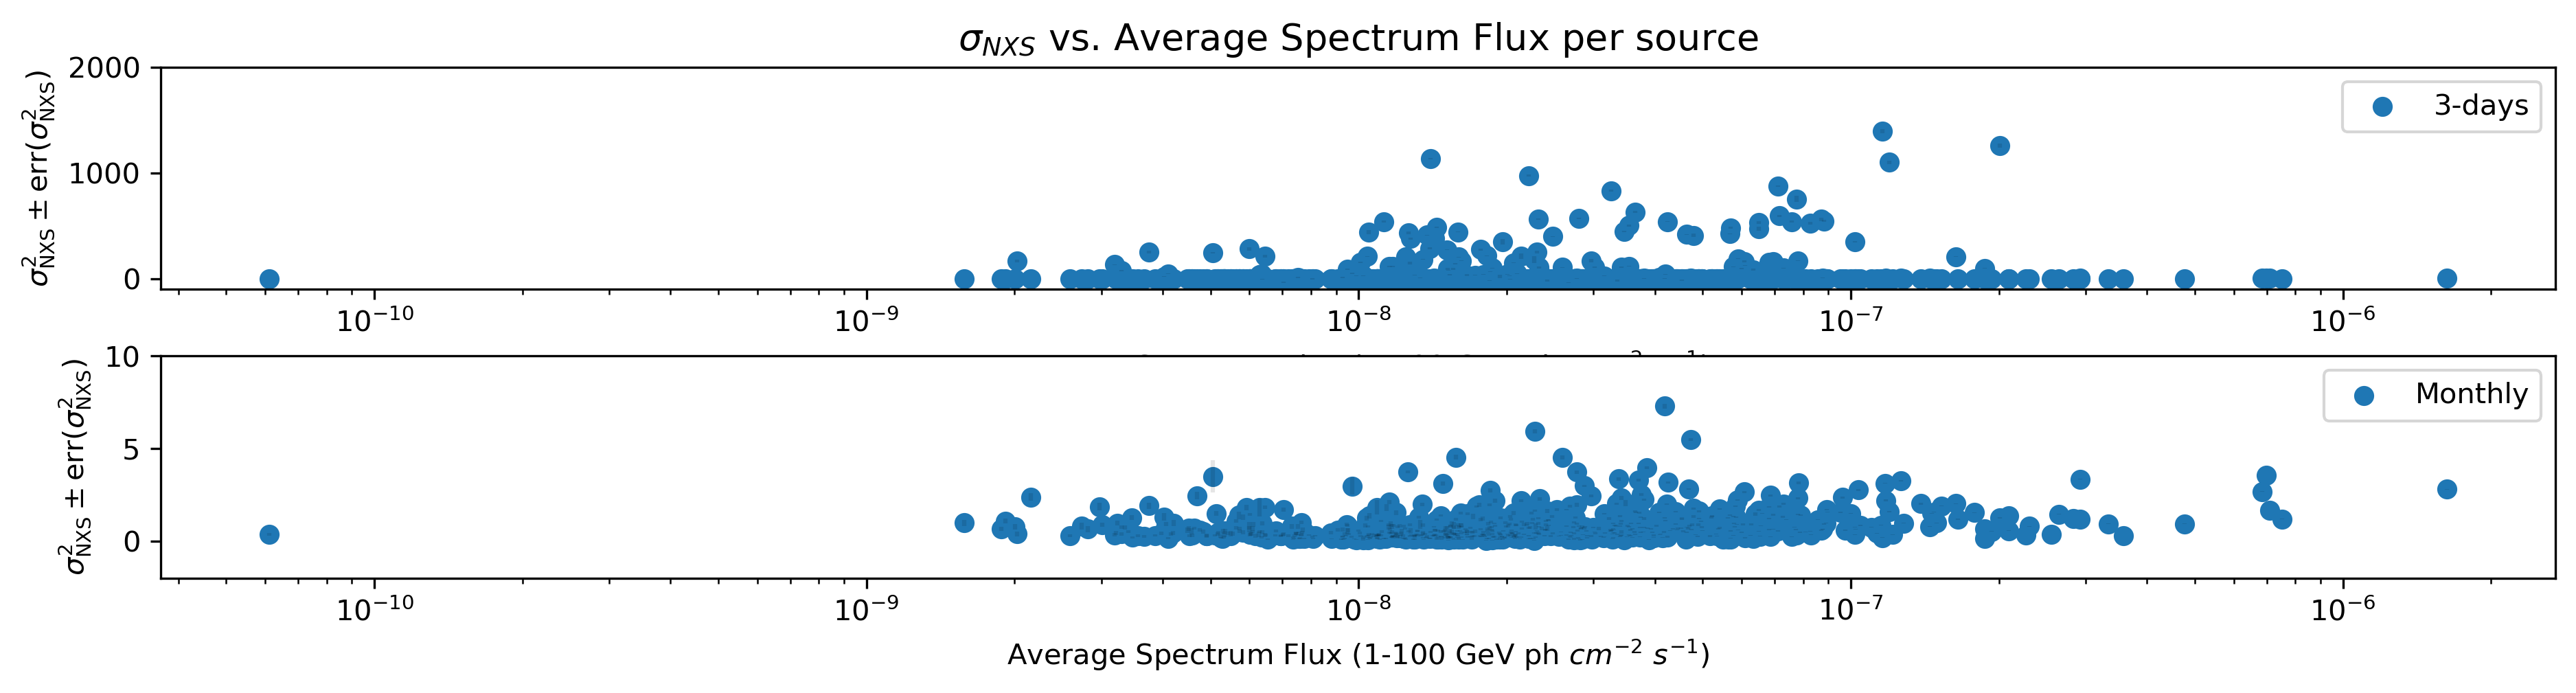

In [77]:
grid = plt.GridSpec(4, 1, wspace=0.4, hspace=0.3)

plt.figure(figsize=(15,7), dpi=300)


plt.subplot(grid[0, 0])

plt.scatter(selected_table_3days['Spectrum_Flux_Estimated'], selected_table_3days['Norm_Excess_Variance_Estimated'], label = '3-days')
plt.errorbar(selected_table_3days['Spectrum_Flux_Estimated'], selected_table_3days['Norm_Excess_Variance_Estimated'], yerr = selected_table_3days['Unc_Norm_Excess_Variance_Estimated'], xerr = None, ls='none', ecolor = 'black', alpha = 0.1) 

plt.xscale('log')
# plt.yscale('log')
# plt.xlim(1e-11,1e-3)
plt.ylim(-100,2000)
plt.title('$\sigma_{NXS}$ vs. Average Spectrum Flux per source', fontsize=13)
plt.ylabel('$\sigma_{\mathrm{NXS}}^{2} \pm \mathrm{err}(\sigma_{\mathrm{NXS}}^{2})$', fontsize=10)
plt.xlabel('Average Spectrum Flux (1-100 GeV ph $cm^{-2}$ $s^{-1}$)', fontsize=10)
plt.legend()




plt.subplot(grid[1, 0])

plt.scatter(selected_table_monthly['Spectrum_Flux_Estimated'], selected_table_monthly['Norm_Excess_Variance_Estimated'], label = 'Monthly')
plt.errorbar(selected_table_monthly['Spectrum_Flux_Estimated'], selected_table_monthly['Norm_Excess_Variance_Estimated'], yerr = selected_table_monthly['Unc_Norm_Excess_Variance_Estimated'], xerr = None, ls='none', ecolor = 'black', alpha = 0.1) 

plt.xscale('log')
# plt.yscale('log')
# plt.xlim(1e-11,1e-3)
plt.ylim(-2,10)
plt.ylabel('$\sigma_{\mathrm{NXS}}^{2} \pm \mathrm{err}(\sigma_{\mathrm{NXS}}^{2})$', fontsize=10)
plt.xlabel('Average Spectrum Flux (1-100 GeV ph $cm^{-2}$ $s^{-1}$)', fontsize=10)
plt.legend()

/Users/luanareis/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:171: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order, subok=True)


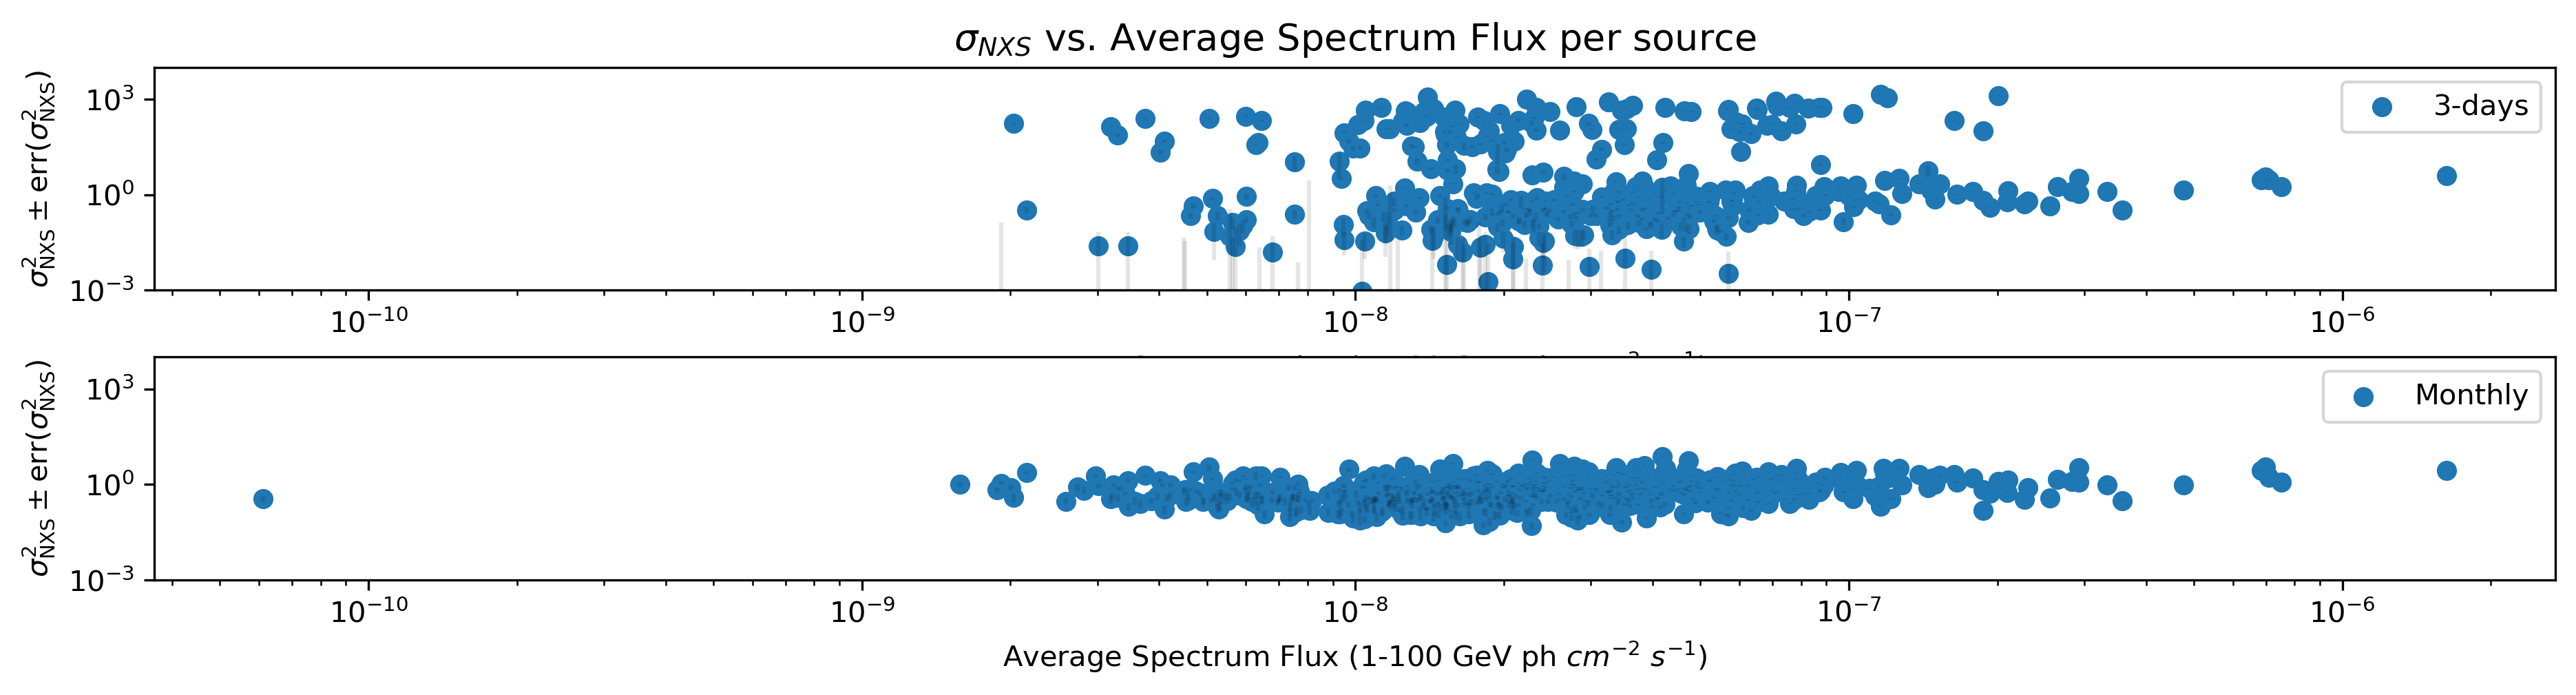

In [78]:
grid = plt.GridSpec(4, 1, wspace=0.4, hspace=0.3)

plt.figure(figsize=(15,7), dpi=300)


plt.subplot(grid[0, 0])

plt.scatter(selected_table_3days['Spectrum_Flux_Estimated'], selected_table_3days['Norm_Excess_Variance_Estimated'], label = '3-days')
plt.errorbar(selected_table_3days['Spectrum_Flux_Estimated'], selected_table_3days['Norm_Excess_Variance_Estimated'], yerr = selected_table_3days['Unc_Norm_Excess_Variance_Estimated'], xerr = None, ls='none', ecolor = 'black', alpha = 0.1) 

plt.xscale('log')
plt.yscale('log')
# plt.xlim(1e-11,1e-3)
plt.ylim(1e-3,1e4)
plt.title('$\sigma_{NXS}$ vs. Average Spectrum Flux per source', fontsize=13)
plt.ylabel('$\sigma_{\mathrm{NXS}}^{2} \pm \mathrm{err}(\sigma_{\mathrm{NXS}}^{2})$', fontsize=10)
plt.xlabel('Average Spectrum Flux (1-100 GeV ph $cm^{-2}$ $s^{-1}$)', fontsize=10)
plt.legend()




plt.subplot(grid[1, 0])

plt.scatter(selected_table_monthly['Spectrum_Flux_Estimated'], selected_table_monthly['Norm_Excess_Variance_Estimated'], label = 'Monthly')
plt.errorbar(selected_table_monthly['Spectrum_Flux_Estimated'], selected_table_monthly['Norm_Excess_Variance_Estimated'], yerr = selected_table_monthly['Unc_Norm_Excess_Variance_Estimated'], xerr = None, ls='none', ecolor = 'black', alpha = 0.1) 

plt.xscale('log')
plt.yscale('log')
# plt.xlim(1e-11,1e-3)
plt.ylim(1e-3,1e4)
plt.ylabel('$\sigma_{\mathrm{NXS}}^{2} \pm \mathrm{err}(\sigma_{\mathrm{NXS}}^{2})$', fontsize=10)
plt.xlabel('Average Spectrum Flux (1-100 GeV ph $cm^{-2}$ $s^{-1}$)', fontsize=10)
plt.legend()

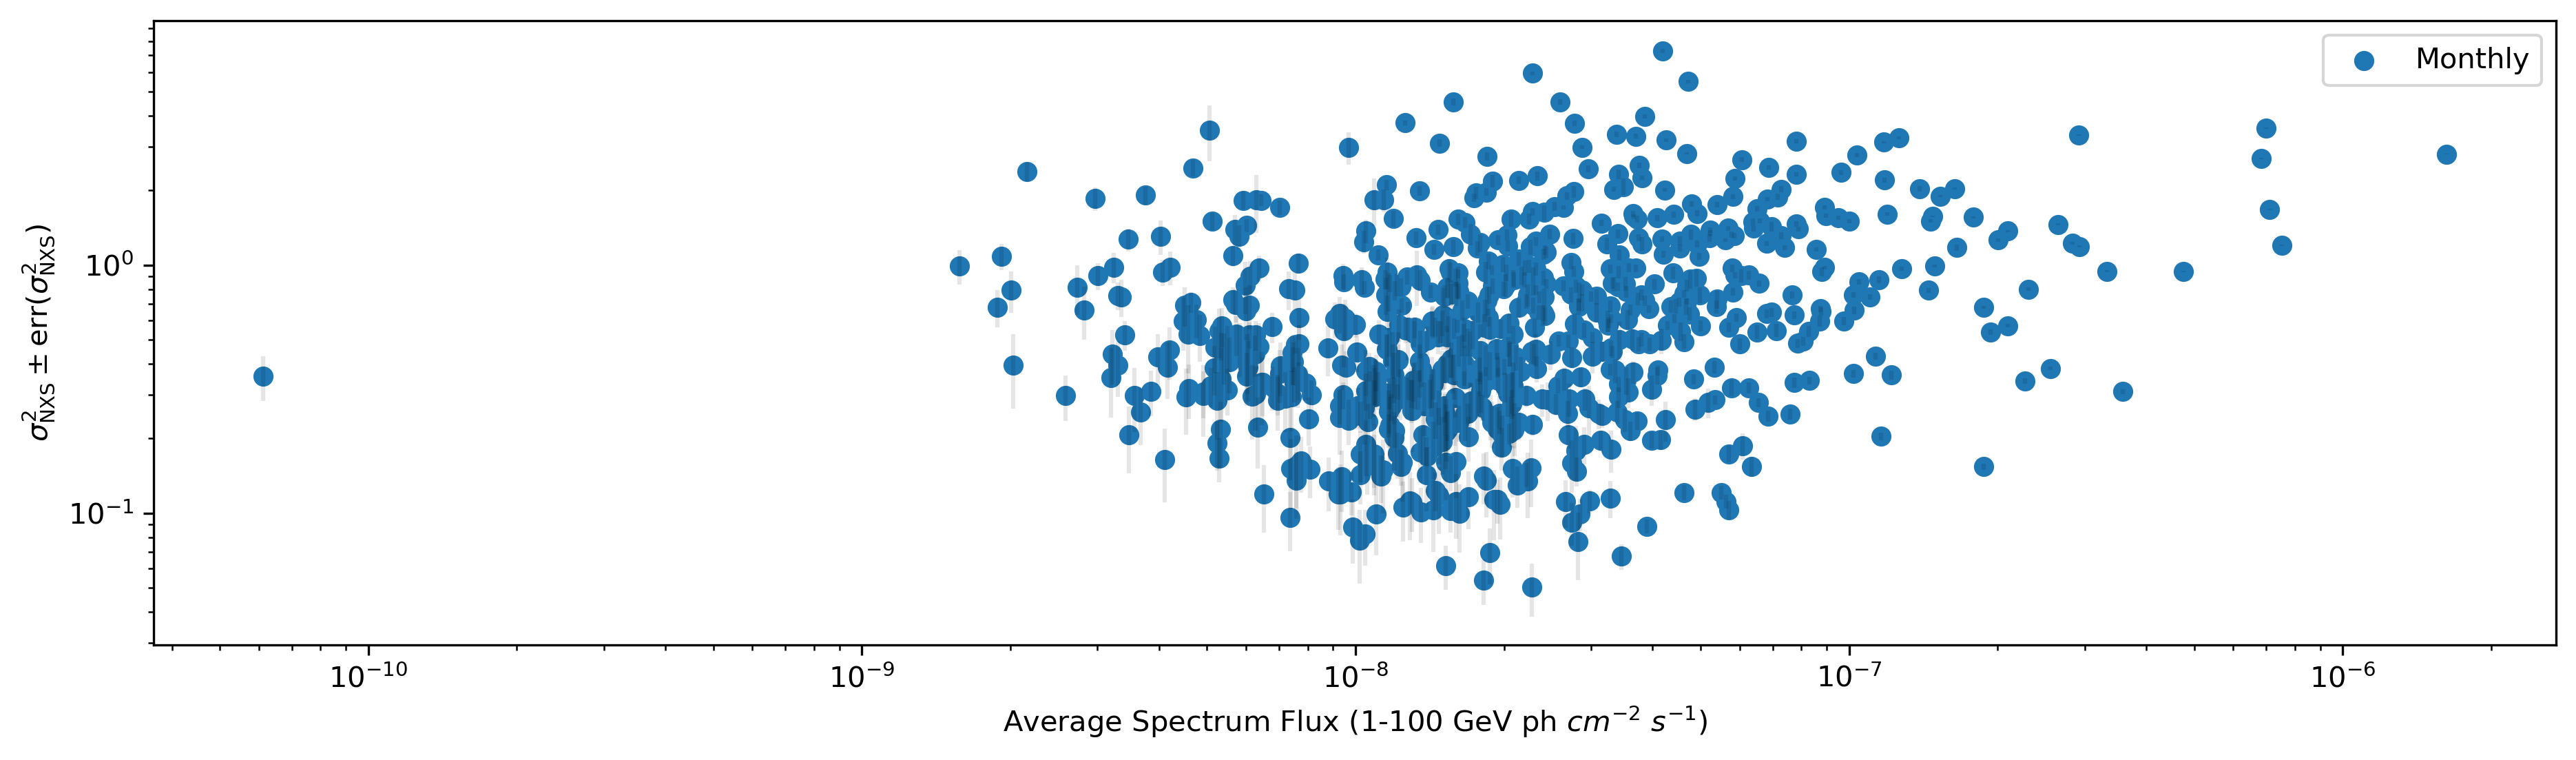

In [79]:
plt.figure(figsize=(15,4), dpi=300)

plt.scatter(selected_table_monthly['Spectrum_Flux_Estimated'], selected_table_monthly['Norm_Excess_Variance_Estimated'], label = 'Monthly')
plt.errorbar(selected_table_monthly['Spectrum_Flux_Estimated'], selected_table_monthly['Norm_Excess_Variance_Estimated'], yerr = selected_table_monthly['Unc_Norm_Excess_Variance_Estimated'], xerr = None, ls='none', ecolor = 'black', alpha = 0.1) 

plt.xscale('log')
plt.yscale('log')
# plt.xlim(1e-11,1e-3)
# plt.ylim(-5,45)
plt.ylabel('$\sigma_{\mathrm{NXS}}^{2} \pm \mathrm{err}(\sigma_{\mathrm{NXS}}^{2})$', fontsize=10)
plt.xlabel('Average Spectrum Flux (1-100 GeV ph $cm^{-2}$ $s^{-1}$)', fontsize=10)
plt.legend()


In [80]:
## testing the functions - dataframe and outliers

source_dictionary, source_df = read_json_catalog('4FGL+J0001.2-0747.json', '3-days')

In [81]:
# source_dictionary

In [82]:
source_df

,fit_convergence,time_ts,values_ts,flux,flux_upper_limits,flux_error
time_fit_convergence,,,,,,
239716801,0,239716801.0,2.42,2.490000e-08,NaN,2.300000e-08
239976001,0,239976001.0,0.00,NaN,4.930000e-08,NaN
240235201,0,240235201.0,0.00,NaN,4.020000e-08,NaN
240494401,0,240494401.0,0.87,NaN,6.960000e-08,NaN
240753601,0,240753601.0,1.42,2.140000e-08,NaN,2.180000e-08
...,...,...,...,...,...,...
727790401,0,727790401.0,0.00,NaN,7.410000e-08,NaN
728049601,0,728049601.0,0.00,NaN,4.370000e-08,NaN
728308801,0,728308801.0,0.00,NaN,8.050000e-08,NaN


In [83]:
filtered_df = removing_outliers(source_df)

/Users/luanareis/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [84]:
filtered_df

,fit_convergence,time_ts,values_ts,flux,flux_upper_limits,flux_error
time_fit_convergence,,,,,,
239716801,0,239716801.0,2.42,2.490000e-08,NaN,2.300000e-08
239976001,0,239976001.0,0.00,NaN,4.930000e-08,NaN
240235201,0,240235201.0,0.00,NaN,4.020000e-08,NaN
240494401,0,240494401.0,0.87,NaN,6.960000e-08,NaN
240753601,0,240753601.0,1.42,2.140000e-08,NaN,2.180000e-08
...,...,...,...,...,...,...
727790401,0,727790401.0,0.00,NaN,7.410000e-08,NaN
728049601,0,728049601.0,0.00,NaN,4.370000e-08,NaN
728308801,0,728308801.0,0.00,NaN,8.050000e-08,NaN


In [85]:
filtered_df.reset_index(inplace=True)

In [86]:
filtered_df

,time_fit_convergence,fit_convergence,time_ts,values_ts,flux,flux_upper_limits,flux_error
0,239716801,0,239716801.0,2.42,2.490000e-08,NaN,2.300000e-08
1,239976001,0,239976001.0,0.00,NaN,4.930000e-08,NaN
2,240235201,0,240235201.0,0.00,NaN,4.020000e-08,NaN
3,240494401,0,240494401.0,0.87,NaN,6.960000e-08,NaN
4,240753601,0,240753601.0,1.42,2.140000e-08,NaN,2.180000e-08
...,...,...,...,...,...,...,...
1875,727790401,0,727790401.0,0.00,NaN,7.410000e-08,NaN
1876,728049601,0,728049601.0,0.00,NaN,4.370000e-08,NaN
1877,728308801,0,728308801.0,0.00,NaN,8.050000e-08,NaN
1878,728568001,0,728568001.0,7.30,1.880000e-08,NaN,1.850000e-08


In [87]:
## select only non-NaN values from the DataFrame
non_nan_values = filtered_df.dropna(subset=['flux'])

# ## get the indexes of the non-NaN values
# non_nan_indexes = non_nan_values.index

## access the flux values and their corresponding indexes
selected_flux_values = non_nan_values['flux'].values

selected_ts_values = non_nan_values['values_ts'].values

In [88]:
print("Non-NaN flux values:")
# print(selected_flux_values)

print("\nCorresponding indexes:")
# print(non_nan_indexes)

Non-NaN flux values:

Corresponding indexes:


In [89]:
# selected_ts_values

In [90]:
filtered_df

,time_fit_convergence,fit_convergence,time_ts,values_ts,flux,flux_upper_limits,flux_error
0,239716801,0,239716801.0,2.42,2.490000e-08,NaN,2.300000e-08
1,239976001,0,239976001.0,0.00,NaN,4.930000e-08,NaN
2,240235201,0,240235201.0,0.00,NaN,4.020000e-08,NaN
3,240494401,0,240494401.0,0.87,NaN,6.960000e-08,NaN
4,240753601,0,240753601.0,1.42,2.140000e-08,NaN,2.180000e-08
...,...,...,...,...,...,...,...
1875,727790401,0,727790401.0,0.00,NaN,7.410000e-08,NaN
1876,728049601,0,728049601.0,0.00,NaN,4.370000e-08,NaN
1877,728308801,0,728308801.0,0.00,NaN,8.050000e-08,NaN
1878,728568001,0,728568001.0,7.30,1.880000e-08,NaN,1.850000e-08


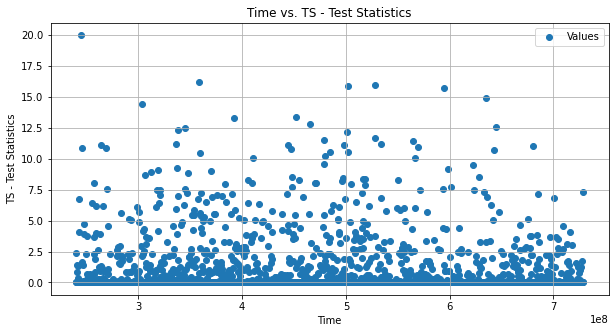

In [91]:
# Plotting the data
plt.figure(figsize=(10, 5))
plt.scatter(filtered_df['time_ts'], filtered_df['values_ts'], label='Values')
plt.xlabel('Time')
plt.ylabel('TS - Test Statistics')
plt.title('Time vs. TS - Test Statistics')
plt.grid(True)
plt.legend()

Convert the Astropy Table to a Pandas DataFrame

In [92]:
# df_agn_pop_4lac_dr3 = table_agn_pop_4lac_dr3.to_pandas()

In [93]:
# df_agn_pop_4lac_dr3